### This notebook creates the plots for 

### *A Probabilistic Autoencoder for Type Ia Supernovae*

Note that the dataset is not yet public, so most figures as they appear in the paper cannot be directly reproduced. But, this notebook should give a clear example on how the analysis was performed, and how to reproduce a similar analysis on another dataset.

The trained models are made public, and you will find them in `../outputs/`

### Load necessary packages and data

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)
print('devices: ', tf.config.list_physical_devices('GPU') )

tfk  = tf.keras
tfkl = tf.keras.layers
print("TFK Version", tfk.__version__)

# %pip install tensorflow-probability==0.9.0                                                                          
import tensorflow_probability as tfp

tfb  = tfp.bijectors
tfd  = tfp.distributions
print("TFP Version", tfp.__version__)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#%matplotlib inline

from matplotlib import rcParams
import matplotlib.patches as patches

import numpy as np
import os
import time
from pprint import pprint

import tensorboard.plugins.hparams as HParams
import argparse

from suPAErnova.utils.YParams import YParams
from suPAErnova.utils.data_loader import *
from suPAErnova.utils.calculations import *

from suPAErnova.models.losses import *
from suPAErnova.models.posterior import *

from suPAErnova.models import loader 
from suPAErnova.models import flows

fs = 16

#SET UP FIGURE AESTHETICS 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 18,                                                                                                                                                    
                     'axes.labelsize': 18, 'legend.fontsize': 16, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 
                     'axes.linewidth': 1.})                                                                                                                                                                    


fs = 16

params = {'text.usetex' : True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica Neue"]}

figdir = '../figures/'

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('viridis')
cmap_scatter = truncate_colormap(cmap, 0.0, 1.0)
cmap_spectra = plt.get_cmap('coolwarm')

tensorflow version:  2.2.0
devices:  []
TFK Version 2.3.0-tf
TFP Version 0.10.1


### Create colorlaw using the *extinction* package

https://extinction.readthedocs.io/en/latest/

In [2]:
# import extinction
# # Load the fiducial color law.
# av = 1.0
# Rv = 2.8
# wave = train_data['wavelengths']
# color_law = extinction.fitzpatrick99(
#             train_data['wavelengths'], av, Rv
#         )

# np.savetxt("../data/F99_colorlaw.txt", np.c_[wave, color_law])
                                            
# w, color_law_old, CL_deriv = np.loadtxt("../data/F99_colorlaw_old.txt", unpack=True)
# plt.plot(train_data['wavelengths'], color_law_old)
# plt.plot(train_data['wavelengths'], color_law)

# plt.figure()
# plt.plot(train_data['wavelengths'], color_law_old/color_law)



### Load in trained models and outputs

In [3]:
want_models = True

latent_dim = 3 
kfold = 0

# savefig = True 
savefig = False

file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0' 

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

param_file = '../outputs/params/AE_kfold{:d}_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
                                                                                      
# Load data
def load_data(file_path):
    return np.load(file_path, allow_pickle=True).item()

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

params['min_train_redshift'] = 0.02
params['max_train_redshift'] = 1.00
params['max_light_cut'] = [-10, 40]
params['twins_cut'] = False

if want_models:
    # Load in models, as well as the outputs above
    parser = argparse.ArgumentParser()
    parser.add_argument("--yaml_config", default='../config/posterior_analysis.yaml', type=str)
    parser.add_argument("--config", default='posterior', type=str)
    parser.add_argument("--print_params", default=True, action='store_true')

    args = parser.parse_args(args=[])

    params = YParams(os.path.abspath(args.yaml_config), args.config, print_params=True)            
    params['latent_dim'] = latent_dim

#     params = np.load(param_file, allow_pickle=True).item()['parameters']
    params['nlayers'] = 12
    params['nunit'] =  8

    pprint(vars(params))
    # Get PAE model"
    PAE = loader.PAE(params)

    istart = 2

    # get latent representations from encoder and flow                                                                       
    train_data['z_latent'] = PAE.encoder((train_data['spectra'], train_data['times'], train_data['mask'])).numpy()
    test_data['z_latent']  = PAE.encoder((test_data['spectra'], test_data['times'], test_data['mask'])).numpy()

    train_data['u_latent'] = PAE.flow.bijector.inverse(train_data['z_latent'][:, istart:]).numpy()
    test_data['u_latent']  = PAE.flow.bijector.inverse(test_data['z_latent'][:, istart:]).numpy()

    # get reconstructions
    train_data['spectra_ae'] = PAE.decoder((train_data['z_latent'], train_data['times'], train_data['mask'])).numpy()
    test_data['spectra_ae']  = PAE.decoder((test_data['z_latent'], test_data['times'], test_data['mask'])).numpy()


------------------ Configuration ------------------
nchains 25
find_MAP True
stop_ratio 0.0001
max_iterations 2500
max_line_search_iterations 50
tolerance 0.01
run_HMC True
ihmc True
num_burnin_steps 10000
num_samples 10000
num_leapfrog_steps 5
step_size 0.05
dtime_norm 1.0
target_accept_rate 0.651
seed 23581
batch_size 171
train_noise False
vary_mask False
lr 0.001
noise_scale 1.0
mask_vary_frac 0.2
rMAPini False
train_MAP True
train_amplitude True
train_dtime True
train_bias False
savedata True
PROJECT_DIR /global/cscratch1/sd/gstein/machine_learning/sn_project/suPAErnova/
FIG_DIR figures/
DATA_DIR data/
OUTPUT_DIR outputs/
MODEL_DIR outputs/tensorflow_models/
PARAM_DIR outputs/params/
LOG_DIR logs/
verbose True
train_data_file data/train_data_kfold0.npy
test_data_file data/test_data_kfold0.npy
kfold 0
colorlaw_file data/F99_colorlaw.txt
out_file_tail 3stage_train_decorrelate_all_seed2
posterior_file_tail 3stage_train_decorrelate_all_seed2
model_summary True
savefig False
savemodel T

## Construct plotting functions for custom corner plots

In [4]:
import matplotlib.gridspec as gridspec
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import pearsonr
import matplotlib.patheffects as pe

# cmap = plt.cm.cividis
def plot_grid(data, labels=None, errs=None, 
              color_arr=None, color_label=None, color_symmetric=False,
              plot_density=False, plot_diagonal=False,
              xyminmax=None,
              figsize=(8,8), spacing=0.05, s=30, ms_mean=6, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False, include_mean=False, nbins=25, nbins_contour=15,
             show_correlation=True, fontsize=12):
    
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    
    # colors = plt.cm.coolwarm_r(np.linspace(0.6, 1.0, 256))
    # colors[0:4, :3] = 1.
    # colors_1D = colors[int(0.8*colors.shape[0])]
    colors = cmap(np.linspace(0.0, 1.0, 256))
    colors_1D = cmap(0.8)

    
    # cmap = LinearSegmentedColormap.from_list('my_colormap', colors)

    sigmas = np.array([1., 2.])#, 3.]) # sigmas
    colors_contour = plt.cm.coolwarm(np.linspace(0.6, 1.0, 256))
    # contour_colors = colors_contour[ np.linspace(0, colors_contour.shape[0]-1, sigmas.shape[0]).astype(int) ]
    contour_colors = np.zeros((len(sigmas), 4))
    contour_colors[:, -1] = np.linspace(0.2, 0.7, contour_colors.shape[0])

    nx = data.shape[1] - 1
    ny = data.shape[1] - 1
    istart = 1
    jstart = 1
    
    if plot_density:
        plot_diagonal=True
    if not plot_diagonal:
        istart = 0
        jstart = 0

    if color_arr is None:
        color_arr_plt = color_arr
    else:
        color_arr_plt = color_arr.copy()

    if color_symmetric:
        # cminmax = min(np.abs(np.min(color_arr_plt)), np.abs(np.max(color_arr_plt)))
        cminmax = 0.25
        color_arr_plt[color_arr_plt < -cminmax] = -cminmax
        color_arr_plt[color_arr_plt > cminmax] = cminmax

    if labels is None:
        labels = ['z_{:d}'.format(i) for i in range(data.shape[1])]
        
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=ny+jstart, nrows=nx+istart, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)

    if cmap is None:
        cmap = plt.cm.viridis
       
    if plot_diagonal:
        for i in range(data.shape[1]):
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[i, i])
            
            ax.hist(data[:, jj], histtype='step', 
                    lw=2, 
                    bins=nbins, 
                    color=colors_1D)
            
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')
            
            ax.set_yticklabels([])
            ax.set_yticks([])
            if i == data.shape[1] - 1:
                ax.set_xlim(data[:, jj].min(), data[:, jj].max() )
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=30)

            if i < data.shape[1] - 1:
                ax.set_xticklabels([])
                      
    for i in range(nx):
        for j in range(i, ny):
            
            ii = ny-j 
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[j+jstart, i])
            if color_arr_plt is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr_plt.min(), color_arr_plt.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels[ii])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels[jj])
            else:
                ax.set_xticklabels([])

            if not plot_density:
                if color_arr_plt is None:
                    if errs is None:
                        ax.scatter(data[:, jj], data[:, ii], s=s, alpha=alpha, rasterized=rasterized)
                    else:
                        ax.errorbar(data[:, jj], data[:, ii], xerr=errs[:, jj], yerr=errs[:, ii], marker='o', 
                                    ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                    rasterized=rasterized, ls='none')

                else:
                    if errs is None:
                        c = ax.scatter(data[:, jj], data[:, ii], s=s, c=color_arr_plt, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                        if include_mean:
                            ax.errorbar(np.mean(data[:, jj]), np.mean(data[:, ii]), xerr=np.std(data[:, jj]), yerr=np.std(data[:, ii]),
                                       ms=ms_mean, marker='o', markeredgecolor='k',
                                       color='w', lw=2, alpha=alpha)

                    else:
                        carr = (color_arr_plt-color_arr_plt.min())/(color_arr_plt.max()-color_arr_plt.min())
                        for ierr in range(data[:, jj].shape[0]):
                            ax.errorbar(data[ierr, jj], data[ierr, ii], xerr=errs[ierr, jj], yerr=errs[ierr, ii], markeredgecolor=markeredgecolor,
                                        color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                         lw=2)
                if show_correlation:
                    r, _ = pearsonr(data[:, jj], data[:, ii])
                    ax.text(0.96, 0.96, f"r={r:.2f}",
                            horizontalalignment='right',
                            verticalalignment='top',
                            transform=ax.transAxes,
                            path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()],
                           fontsize=fontsize)

            if plot_density:
                ax.hexbin(data[:, jj], data[:, ii], gridsize=nbins, cmap=cmap)#, norm=matplotlib.colors.LogNorm())
                # ax.contour(counts)#, extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()],
                           # linewidths=3)
                H, xedges, yedges = np.histogram2d(data[:, jj], data[:, ii], bins=nbins_contour)#, bins=(xedges, yedges))

                H /= H.sum()

                n = 10000
                t = np.linspace(0, H.max(), n)
                integral = ((H >= t[:, None, None]) * H).sum(axis=(1,2))

                intervals = (1 - np.exp(-(sigmas)**2/2)) # CDF in 2D

                f = interpolate.interp1d(integral, t)
                t_contours = f(intervals[::-1])
                ax.contour(H.T, t_contours, 
                           extent=[data[:, jj].min(), data[:,jj].max(), data[:,ii].min(), data[:,ii].max()],
                          colors=contour_colors)
                if include_mean:
                        ax.errorbar(np.mean(data[:, jj]), np.mean(data[:, ii]), xerr=np.std(data[:, jj]), yerr=np.std(data[:, ii]),
                                    ms=ms_mean, marker='o', markeredgecolor='w',
                                    color='k', lw=2, alpha=alpha)
                        
            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
            # else:
            #     ax.set_ylim(data[:, ii].min(), data[:, ii].max() )
            #     ax.set_xlim(data[:, jj].min(), data[:, jj].max() )
                
            if j == ny-1:
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=30)

            if i == 0:
                xti = ax.get_yticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_yticklabels(xti)
                
    if color_arr_plt is not None:
        cax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')
  

def plot_grid_one_vs_other(data1, data2, 
                           labels1=None, labels2=None, 
                           errs1=None, errs2=None, 
                           color_arr=None, color_label=None, xyminmax=None, color_symmetric=False,
              figsize=(8,8), spacing=0.05, s=30, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False,
                          show_correlation=True, fontsize=12):
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    nx = data1.shape[1]
    ny = data2.shape[1]
    print(nx, ny)
    
    if color_symmetric:
        # Assume magnitude

        cmin = -0.25
        cmax = 0.25
        color_arr[color_arr < cmin] = cmin
        color_arr[color_arr > cmax] = cmax

    if labels1 is None:
        labels1 = ['z1_{:d}'.format(i) for i in range(data1.shape[1])]
    if labels2 is None:
        labels2 = ['z2_{:d}'.format(i) for i in range(data2.shape[1])]
                
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=nx, nrows=ny, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)

    if cmap is None:
        cmap = plt.cm.viridis
       
    for i in range(nx):
        for j in range(ny):
            ax = fig.add_subplot(gs[j, i])
            if color_arr is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr.min(), color_arr.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels2[j])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels1[i])
            else:
                ax.set_xticklabels([])

            if color_arr is None:
                if errs1 is None:
                    ax.scatter(data1[:, i], data2[:, j], s=s, alpha=alpha, rasterized=rasterized)
                else:
                    ax.errorbar(data1[:, i], data2[:, j], xerr=errs1[:, i], yerr=errs2[:, j], marker='o', 
                                ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                rasterized=rasterized, ls='none')

            else:
                if errs1 is None:
                    c = ax.scatter(data1[:, i], data2[:, j], s=s, c=color_arr, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                else:
                    carr = (color_arr-color_arr.min())/(color_arr.max()-color_arr.min())
                    # carr = color_arr
                    for ierr in range(data1[:, i].shape[0]):
                        ax.errorbar(data1[ierr, i], data2[ierr, j], xerr=errs1[ierr, i], yerr=errs2[ierr, j], markeredgecolor=markeredgecolor,
                                    color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                     lw=2)

            if show_correlation:
                r, _ = pearsonr(data1[:, i], data2[:, j])
                ax.text(0.96, 0.96, f"r={r:.2f}",
                        horizontalalignment='right',
                        verticalalignment='top',
                        transform=ax.transAxes,
                        path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()],
                       fontsize=fontsize)

            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
                
            if j == ny-1:
                xti = ax.get_xticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_xticklabels(xti, rotation=40)

            if i == 0:
                xti = ax.get_yticks()
                xti = ['{:.2f}'.format(it) for it in xti]
                ax.set_yticklabels(xti)
                                
            # if j == ny-1:
            #     ax.set_xticklabels(ax.get_xticks(), rotation=-15)
                
    if color_arr is not None:
        # cax = fig.add_axes([0.98, 0.25, 0.01, 0.5])
        # fig.colorbar(dummie_cax, cax=cax, label=color_label)
        cax = fig.add_axes([0.98, 0.25, 0.01, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')

# 

# Corner Plots

(10000, 57, 6)
SN2010dt
2 (10000, 57, 6)
0.052895
-0.009876186 0.035014264
[ 0.00318197 -0.00987619 -0.13307413 -0.04234766 -0.02578421  0.02486539] [0.0024453  0.03501426 0.03552351 0.01200449 0.0097772  0.01787205]


<ipython-input-4-b9a49100ea5c>:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
<ipython-input-4-b9a49100ea5c>:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-4-b9a49100ea5c>:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)


SN2005bg
38 (10000, 57, 6)
0.022823
-0.29999793 0.047977004
[ 0.02710627 -0.29999793  0.17218938 -0.11695413 -0.12999448  0.03974655] [0.00378963 0.047977   0.04945481 0.01688286 0.01600852 0.01119837]


<ipython-input-4-b9a49100ea5c>:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
<ipython-input-4-b9a49100ea5c>:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-4-b9a49100ea5c>:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


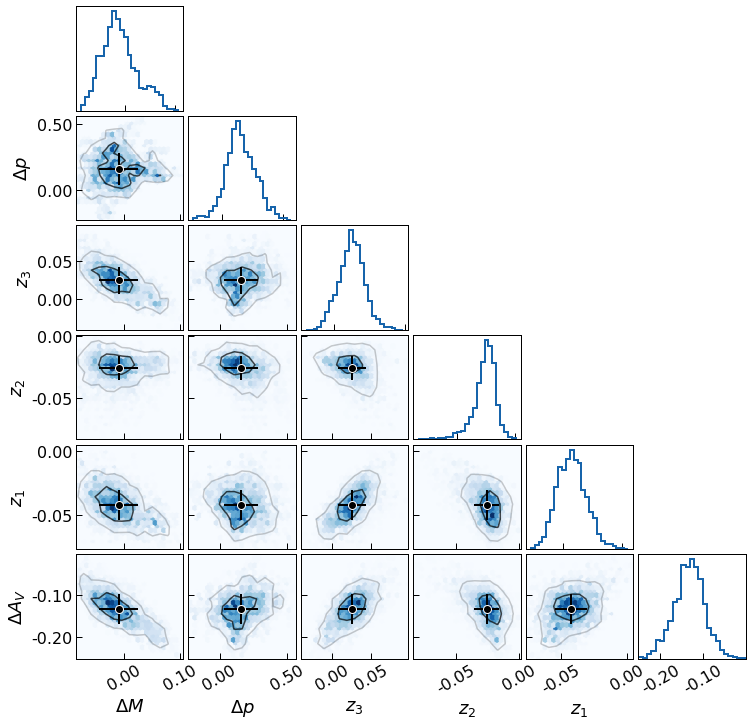

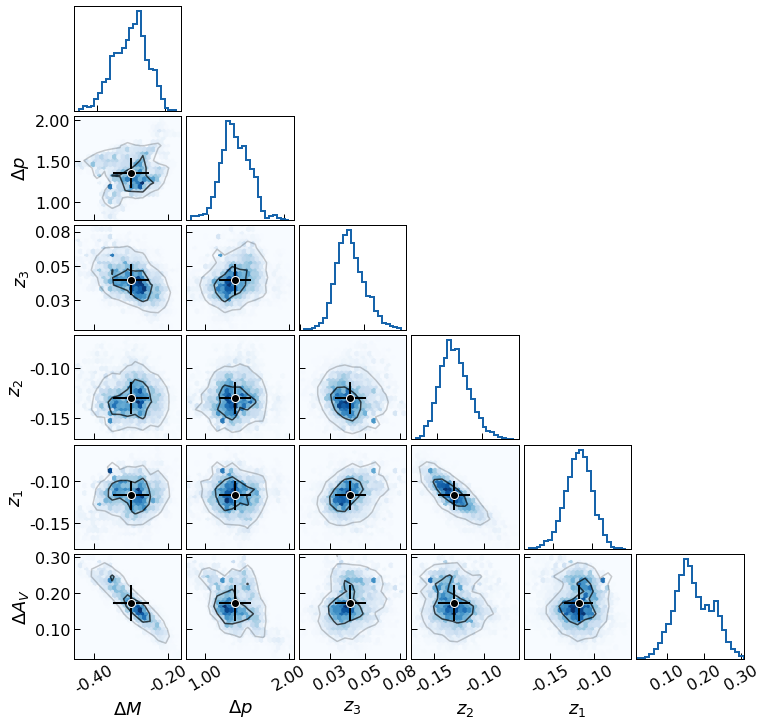

In [5]:
# savefig = True
savefig = False

labels = ['$\Delta p$', '$\Delta M$', '$\Delta A_V$'] + ['$z_{:d}$'.format(i+1) for i in range(latent_dim)]
print(test_data['z_samples'].shape)

z_use = test_data['z_latent'].copy()
z_use[:,0]*=50

# dm = get_train_mask(train_data, params)
# inds = np.argsort(test_data['redshift'])[::-1]
inds = np.arange(test_data['redshift'].shape[0])

inds = [2, 38] #43]#2,24]

# plot_grid(z_use, labels=labels)
for iplt in range(len(inds)):
    print(test_data['names'][inds[iplt]])
    print(inds[iplt], test_data['z_samples'].shape)
    print(test_data['redshift'][inds[iplt]])
    print(test_data['amplitude_mcmc'][inds[iplt]], test_data['amplitude_mcmc_err'][inds[iplt]])
    print(np.mean(test_data['z_samples'][:, inds[iplt], :], axis=0), np.std(test_data['z_samples'][:, inds[iplt], :], axis=0))
    
    zplt = test_data['z_samples'][:, inds[iplt], :].copy()
    zplt[:, 0] *= 50
    
    labelsi = np.roll(labels, -1)
    zplt  = np.roll(zplt, -1, axis=1)

    plot_grid(zplt, 
              labels=labelsi, 
              figsize=(12,12),  s=10, include_mean=True, ms_mean=8,
              plot_density=True, savefig=savefig, filename='../figures/HMC_chains_density_{:03d}_latentdim{:02d}.pdf'.format(inds[iplt], latent_dim),
             cmap=plt.cm.Blues)


['$\\Delta p$', '$\\Delta M$', '$\\Delta A_V$', '$z_1$', '$z_2$', '$z_3$']


<ipython-input-4-b9a49100ea5c>:196: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-4-b9a49100ea5c>:191: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=30)
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


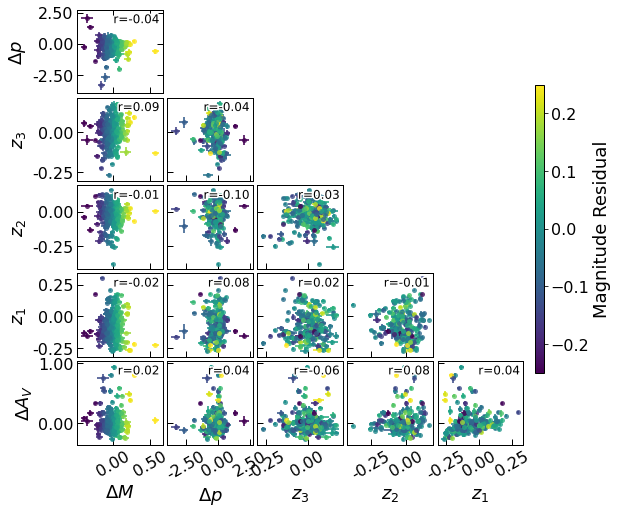

In [6]:
savefig = False
# savefig = True

filename = '../figures/grid_PAE_{:d}Dlatent.pdf'.format(latent_dim)

data = {}
data['z_latent_mcmc'] = np.concatenate((train_data['z_latent_mcmc'], test_data['z_latent_mcmc']), axis=0)
data['z_latent_mcmc_err'] = np.concatenate((train_data['z_latent_mcmc_err'], test_data['z_latent_mcmc_err']), axis=0)

data['z_latent_mcmc'][:,0] *= 50 #days
data['z_latent_mcmc_err'][:,0]  *= 50 #days

data['redshift'] = np.concatenate((train_data['redshift'], test_data['redshift']), axis=0)
data['times_orig'] = np.concatenate((train_data['times_orig'], test_data['times_orig']), axis=0)

labels = ['$\Delta p$', '$\Delta M$', '$\Delta A_V$'] + ['$z_{:d}$'.format(i+1) for i in range(latent_dim)]
print(labels)

dm = get_train_mask(data, params)

arr_use = data['z_latent_mcmc'][dm]
err_use = data['z_latent_mcmc_err'][dm]

labels = np.roll(labels, -1)
arr_use = np.roll(arr_use, -1, axis=1)
err_use = np.roll(err_use, -1, axis=1)

plot_grid(arr_use, errs=err_use, 
          labels=labels, savefig=savefig, filename=filename,
          color_arr=arr_use[:, 0], color_label='Magnitude Residual', color_symmetric=True,
         figsize=(8,8), cmap=cmap_scatter, s=5, alpha=0.8, markeredgecolor='none') 



[-3.54249369e-06 -2.14394322e-03  1.55434515e-02 -8.18996504e-02
 -1.97791699e-02 -9.56705119e-03]


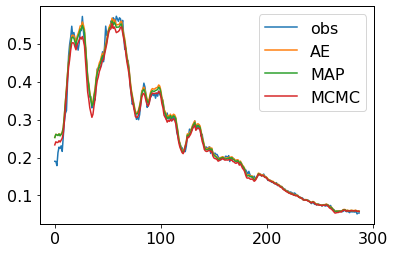

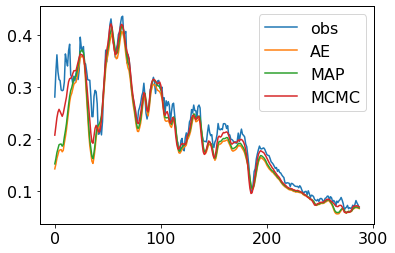

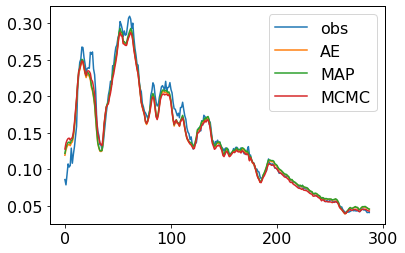

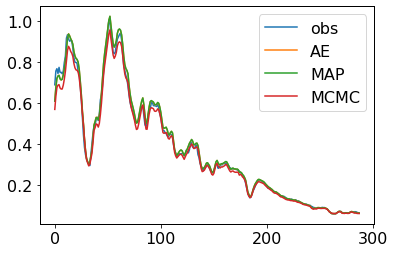

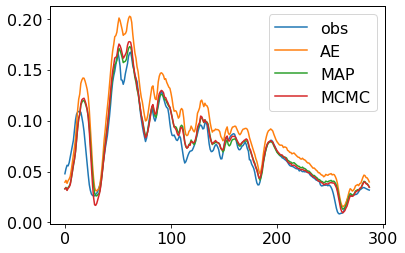

In [7]:
# Simple spectra plots to make sure model is doing what it should be
for iplt in range(5):
    plt.figure()
    plt.plot(train_data['spectra'][iplt,0], label='obs')
    plt.plot(train_data['spectra_ae'][iplt,0], label='AE')
    plt.plot(train_data['spectra_map'][iplt,0], label='MAP')
    plt.plot(train_data['spectra_mcmc'][iplt,0], label='MCMC')#*10**(-0.4*-0.34430096))

    plt.legend()
    
print(train_data['z_latent'].mean(0))

### Play around with synthetic photometry

source:
  class      : SALT2Source
  name       : 'salt2'
  version    : 2.4
  phases     : [-20, .., 50] days
  wavelengths: [2000, .., 9200] Angstroms
parameters:
  z  = 0.05
  t0 = 0.0
  x0 = 1.0
  x1 = 0.0
  c  = 0.0
[3302. 4102.]
(10,) (10, 288) (10,)
[4102. 5100.]
(10,) (10, 288) (10,)
[5200. 6289.]
(10,) (10, 288) (10,)
[6289. 7607.]
(10,) (10, 288) (10,)
[7607. 8598.]
(10,) (10, 288) (10,)


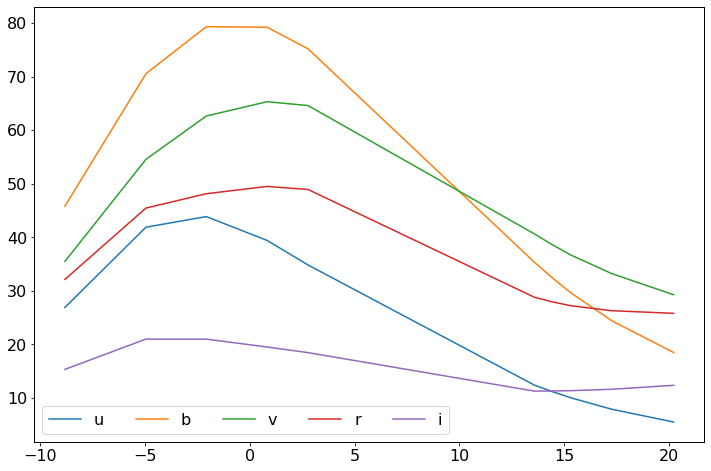

In [11]:
import sncosmo

def obs_from_rf_factor(z): #, cosmo=COSMO):
    return z

    # factor = 1/1e15
    # factor = factor*(1.05)/(1+z)
    # dlref = cosmo.luminosity_distance(0.05).value
    # dl = cosmo.luminosity_distance(z).value
    # factor = factor * dlref**2 / dl**2
    # return factor

def lc_from_spectra(band, fluxes, z, phases, spec_ids, flux_errs=None):
    lc = []
    for i, (phase, spec_id) in enumerate(zip(phases, spec_ids)):
        fac = obs_from_rf_factor(z)
        flux = fluxes[spec_id] * fac
        if flux_errs is not None:
            fluxerr = flux_errs[spec_id] * fac
        else:
            fluxerr = None
        spec = sncosmo.Spectrum(wave=obs_wave*(1+z), flux=flux, fluxerr=fluxerr, time=phase)
        lc.append(spec.bandfluxcov(band))
    return lc

dm = 0.
av = 0.
xi1 = 0.
xi2 = 0.
xi3 = 0.
z = 0.05

filter_edges = {'u': np.array([3302., 4102.]),
                'b': np.array([4102., 5100.]),
                'v': np.array([5200., 6289.]),
                'r': np.array([6289., 7607.]),
                'i': np.array([7607., 8598.])}

model = sncosmo.Model(source='salt2')
model.set(t0=0, z=z)
model.wavelengths = train_data['wavelengths']
delta_dm = -2.5*np.log10(obs_from_rf_factor(z))
model_phases = np.linspace(-10, 40, 100)

wavelength = [4000., 5000.]
transmission = [1., 1.]

print(model)
iplt = 0
nspec = 10

plt.figure(figsize=(12,8))
for band_name, band_edges in filter_edges.items():
    print(band_edges)
    band = sncosmo.Bandpass(band_edges, band_edges*0+1, name=band_name)
    sncosmo.register(band, force=True)
    
        
    phases = train_data['times_orig'][iplt, :nspec, 0]
    model.flux = train_data['spectra'][iplt, :nspec]
    model.phases = phases

    bandflux = model.bandflux(band_name, phases)
    print(phases.shape, model.flux.shape, bandflux.shape)
    plt.plot(phases, bandflux, label=band_name)
    
plt.legend(ncol=5)

[[0.         0.03225806 0.06451613 0.09677419 0.12903226 0.16129032
  0.19354839 0.22580645 0.25806452 0.29032258 0.32258065 0.35483871
  0.38709677 0.41935484 0.4516129  0.48387097 0.51612903 0.5483871
  0.58064516 0.61290323 0.64516129 0.67741935 0.70967742 0.74193548
  0.77419355 0.80645161 0.83870968 0.87096774 0.90322581 0.93548387
  0.96774194 1.        ]] [[-10.          -8.38709677  -6.77419355  -5.16129032  -3.5483871
   -1.93548387  -0.32258065   1.29032258   2.90322581   4.51612903
    6.12903226   7.74193548   9.35483871  10.96774194  12.58064516
   14.19354839  15.80645161  17.41935484  19.03225806  20.64516129
   22.25806452  23.87096774  25.48387097  27.09677419  28.70967742
   30.32258065  31.93548387  33.5483871   35.16129032  36.77419355
   38.38709677  40.        ]]


No handles with labels found to put in legend.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


-2.788427868354179 1.172652127226388


No handles with labels found to put in legend.


-2.7762586783923178 1.3522330890877758


No handles with labels found to put in legend.


-2.742833433087334 1.074153831659499


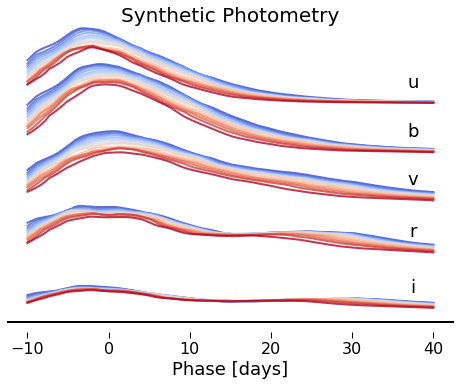

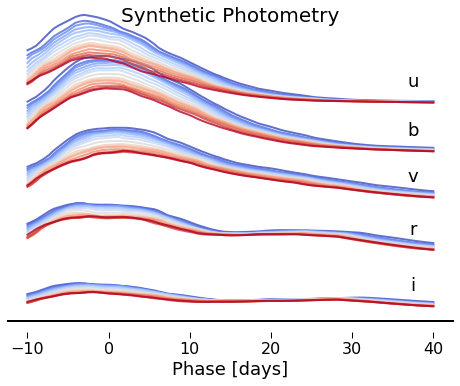

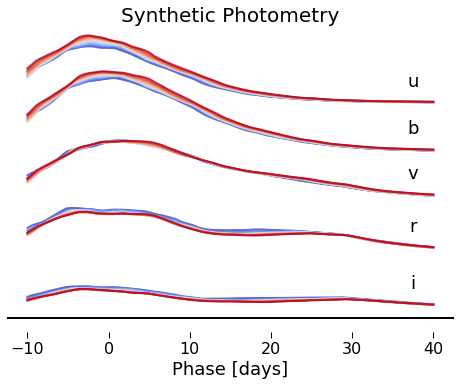

In [11]:
import matplotlib.patheffects as pe
import sncosmo

# Plot SN while varying z latent params to see effects

savefig = True
# savefig = False

figdir = '../figures/'

# Set up figure aesthetics
latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
labels = ['$\Delta t$', '$\Delta M$', '$\Delta A_V$'] + latent


alpha=0.8
dim_plus_2 = 1 #2
lw = 2
# Get observation times and bin latent params
dm = get_train_mask(train_data, params)
z_latent_use = train_data['z_latent_mcmc']

nsamples = 15
percentiles = np.linspace(10, 90, nsamples)
z_bin_edge = np.percentile(z_latent_use, percentiles, axis=0)
nsamples = z_bin_edge.shape[0]

Asamp = np.linspace(0.5, 1.5, nsamples)

nshow = 6 #3
times_lin = np.linspace(0,1, params['n_timestep'])[None, ...]
mask_     = np.ones((1, params['n_timestep'], 288))

times_orig_lin = times_lin*50 - 10

print(times_lin, times_orig_lin)

cmaps = [cmap_spectra] * 5
# cmaps = [plt.cm.Purples, plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.Reds]

colors = [cmap(np.linspace(0.0,1,nsamples)) for cmap in cmaps]

z_median = np.median(z_latent_use[dm], axis=0)[None, ...]

# get u array of zeros
nbands = 5
filter_edges = {'u': np.array([3302., 4102.]),
                'b': np.array([4102., 5100.]),
                'v': np.array([5200., 6289.]),
                'r': np.array([6289., 7607.]),
                'i': np.array([7607., 8598.])}

ntime_splits = 3

for dim in range(3, z_bin_edge.shape[1]):

    aoffsets = [0.75, 1.5]
    zsamp = z_bin_edge[:, dim]
        
    title = 'Varying {:s}'.format(labels[dim])

    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))#, gridspec_kw={'height_ratios': [3, 1]})

    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(1.)

    ax1.tick_params('both', length=6, width=1., which='major', color='k',direction='in')                                         
    ax1.tick_params('both', length=3, width=1., which='minor', color='k',direction='in')

    ymin = 100
    ymax = -100

    # get origin value
    z_ = z_median.copy()

    for sample in range(z_bin_edge.shape[0]):

        # set u values along slice
        z_ = z_median.copy()
        z_[:, dim:dim+dim_plus_2] = zsamp[sample]

        bandfluxes = np.zeros((nbands, params['n_timestep']*ntime_splits))
        phases = []

        isamp = 0
        for itime_mult in range(1, ntime_splits+1):
            # make time difference smaller by factor of this in order to more smoothly interpolate
            times_lin_use = times_lin / ntime_splits + (itime_mult-1.)/ntime_splits
            phases.extend(list(times_lin_use[0]))
            # times_lin_use = np.clip(times_lin_use, 1./50, 1-1./50)

            xpred_i = np.array(PAE.decoder((z_, times_lin_use, mask_))[0]) #/ (10**(-0.4* (CL*np.exp(z_[:, -1]) + z_[:, 0])))

            for ispec in range(params['n_timestep']):

                spec = sncosmo.Spectrum(wave=train_data['wavelengths'], flux=xpred_i[ispec])
                for iband, (band_name, band_edges) in enumerate(filter_edges.items()):
                    band = sncosmo.Bandpass(band_edges, band_edges*0+1, name=band_name)
                    sncosmo.register(band, force=True)

                    bandflux = spec.bandflux(band_name)/1.e14
                    
                    bandfluxes[iband, isamp] = bandflux
                
                    
                isamp += 1

        for iband in range(bandfluxes.shape[0]):
            ax1.plot(np.array(phases)*50-10, bandfluxes[iband]-iband/3*2, c=colors[iband][sample], lw=lw, alpha=alpha)
            
    for iband, (band_name, band_edges) in enumerate(filter_edges.items()):
        ax1.text(37.5,  bandfluxes[iband, -1]-iband/3*2+0.2, band_name, ha='center')
#         for i in range(nshow):
#             labp = None
#             labo = None
#             if i==0:
#                 labs = 'Encoder'
#                 labp = 'MAP'
#             if plttype == 'normal':
#                 xpi = xpred_i[i] + offset[i]
                
                
#         ax1.plot(train_data['wavelengths'], xpi, '-',
#                  c=colors[sample], lw=lw, alpha=alpha,
#                 path_effects=[pe.Stroke(linewidth=lw+1, foreground='w'), pe.Normal()],
#                 )#, label=labp)

  
    ax1.set_ylabel('Normalized Flux')
    ax1.set_xlabel('Phase [days]')

    # ymax = offset[0] + aoffsets[iplt] 
    # ymin = offset[nshow-1]
    # ax1.set_title(title, fontsize=20, y=0.97, pad=0)
    ax1.set_title("Synthetic Photometry", fontsize=20, y=0.97, pad=0)


    
    ax1.set_frame_on(False)
    ax1.get_xaxis().tick_bottom()
    ax1.axes.get_yaxis().set_visible(False)
    xmin, xmax = ax1.get_xaxis().get_view_interval()
    ymin, ymax = ax1.get_yaxis().get_view_interval()
    print(ymin,ymax)
    ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

    ax1.legend(loc='upper right', frameon=False, ncol=3)
    ax1.set_ylim(-3., 1.2)


#     ax1.axis('off')

#     ax2.set_yscale('log')
    # ax1.set_xlim(train_data['wavelengths'][0], train_data['wavelengths'][-1])
#     plt.subplots_adjust(hspace=0.025)

    if savefig: 
        fname = 'vary_zlatent_lc_{:02d}Dlatent_dim{:d}'.format(latent_dim, dim)
        if dim_plus_2 > 1:
            fname = 'vary_zlatent_lc_dimplus2_{:02d}Dlatent_dim{:d}'.format(latent_dim, dim)

        plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')



Text(0, 0.5, 'PAE $\\Delta p$')

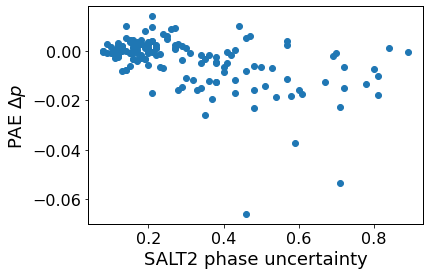

In [15]:
# Correlation of SALT2 time uncertainty and PAE \Delta p parameter
dm = get_train_mask(train_data, params)

plt.scatter(train_data['dphase'][dm], train_data['z_latent_mcmc'][dm, 0])
plt.xlabel("SALT2 phase uncertainty")
plt.ylabel("PAE $\Delta p$")

# Plot spectra and model fits

In [8]:
from scipy.optimize import minimize

def frac_to_mag(fractional_difference):
    """Convert a fractional difference to a difference in magnitude
    Because this transformation is asymmetric for larger fractional changes, we
    take the average of positive and negative differences.
    
    Copied from https://github.com/snfactory/twins_embedding
    """
    pos_mag = 2.5 * np.log10(1. + fractional_difference)
    neg_mag = 2.5 * np.log10(1. - fractional_difference)
    mag_diff = (pos_mag - neg_mag) / 2.0
    return mag_diff

# Fit for the intrinsic dispersion
def gaussian_likelihood(residuals, measurement_uncertainties, intrinsic_dispersion):
    variance = measurement_uncertainties**2 + intrinsic_dispersion**2
    return 1 / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

def negative_log_likelihood(x):
    likelihoods = gaussian_likelihood(residuals, measurement_uncertainties, x[0])
    return -np.sum(np.log(likelihoods))

def compute_intrinsic_dispersion(spec_true, spec_pred, sigma,  weighted=False, outlier_cut=98):
    """Calculate std of a true and reconstructed spectra                                     
                                                                                                                    
    Parameters                                                                                                      
    ----------                                                                                                      
    spec_true: array (N_sn, n_timesamples, data_dim)                                                                
       measured spectra                                                                                             
    spec_pred: array (N_sn, n_timesamples, data_dim)                                                                
       model spectra                                                                                                
    sigma: array (N_sn, n_timesamples, data_dim)                                                                    
       measurement uncertainty                                                                                      
    time: array (N_sn, n_timesamples)                                                                               
       observation time                                                                                             
    """
   
    residuals = np.abs(spec_pred.copy() - spec_true.copy())
    
    # sometimes there are huge outliers,                                                                            
    # so set errors larger than some percentile to the value corresponding to that percentile        
    intrinsic_dispersion = np.zeros(residuals.shape[0])
    
    for wbin in range(residuals.shape[0]):
        measurement_uncertainty = sigma[wbin]
        residual = residuals[wbin]

        # Fit for the intrinsic dispersion
        def gaussian_likelihood(residual, measurement_uncertainty, intrinsic_dispersion_i):
            variance = measurement_uncertainty**2 + intrinsic_dispersion_i**2
            return 1. / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

        def negative_log_likelihood(x):
            likelihoods = gaussian_likelihood(residual, measurement_uncertainty, x[0])
            likelihoods += 1e-9
            return -np.sum(np.log(likelihoods))
        
        if np.abs(residual) > measurement_uncertainty:
            initial_guess = np.sqrt(residual**2 - measurement_uncertainty**2)

            res = minimize(negative_log_likelihood, [initial_guess])
            itrial = 0
            while res.success is False and itrial < 10:
                xini = np.abs(np.random.normal(initial_guess, measurement_uncertainty, 1))
                res = minimize(negative_log_likelihood, xini)
                itrial += 1

            intrinsic_dispersion[wbin] = np.abs(res.x[0])
        else:
            intrinsic_dispersion[wbin] = 0
    
    return  intrinsic_dispersion


def compute_intrinsic_dispersion_vs_time(spec_true, spec_pred, sigma, mask, time, weighted=False, outlier_cut=98, ntbins=10):
    """Calculate std of true and reconstructed spectra as a function of time                                        
                                                                                                                    
    Parameters                                                                                                      
    ----------                                                                                                      
    spec_true: array (N_sn, n_timesamples, data_dim)                                                                
       measured spectra                                                                                             
    spec_pred: array (N_sn, n_timesamples, data_dim)                                                                
       model spectra                                                                                                
    sigma: array (N_sn, n_timesamples, data_dim)                                                                    
       measurement uncertainty                                                                                      
    time: array (N_sn, n_timesamples)                                                                               
       observation time                                                                                             
    """
    dm = np.min(mask, axis=-1) == 1.
    
    t_bin_edge = np.linspace(0, 1, ntbins+1)
    t_bin_cent = (t_bin_edge[:-1] + t_bin_edge[1:])/2
    # print(t_bin_edge *50 -10)
    s0 = spec_true[dm]
    s1 = spec_pred[dm]

    s0[s0 < 0] = 0
    s1[s1 < 0] = 0
    
#     residual = -2.5*np.log10(s1/s0)
#     sig = 2.5*np.log10(np.abs(sigma[dm])/s0)
    
    residual = spec_pred[dm].copy() - spec_true[dm].copy()
    sig = sigma[dm].copy()

    t   = time[dm][:,0]
    
    # print(sig.min(), np.abs(residual).min(), np.abs(residual/sig).min())
    residual = np.reshape(residual, (-1, 288))
    sig = np.reshape(sig, (-1, 288))
    s0 = np.reshape(s0, (-1, 288))
    s1 = np.reshape(s1, (-1, 288))

    # print(sig.shape)
    # sometimes there are huge outliers,                                                                            
    # so set errors larger than some percentile to the value corresponding to that percentile        
    intrinsic_dispersion = np.zeros((len(t_bin_cent), sig.shape[1]))
    measurement_dispersion = np.zeros((len(t_bin_cent), sig.shape[1]))
    mean_spectra = np.zeros((len(t_bin_cent), sig.shape[1]))

    bins = np.digitize(t, t_bin_edge) - 1
#     for tbin in range(1):
    for tbin in np.unique(bins):
        dm   = bins == tbin
#         print(sig[dm].min(0), sig[dm].max(0))
#         print(residual[dm].min(0), residual[dm].max(0))
        mean_spectra[tbin] = s0[dm].mean(0)

        for wbin in range(sig.shape[1]):
            measurement_uncertainties = sig[dm][:, wbin]
            residuals = residual[dm][:, wbin]
            
            # Fit for the intrinsic dispersion
            def gaussian_likelihood(residuals, measurement_uncertainties, intrinsic_dispersion_i):
                variance = measurement_uncertainties**2 + intrinsic_dispersion_i**2
                return 1. / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

            def negative_log_likelihood(x):
                likelihoods = gaussian_likelihood(residuals, measurement_uncertainties, x[0])
                likelihoods += 1e-9
                return -np.sum(np.log(likelihoods))

            mean_resid = np.mean(np.abs(residuals))
#             print(mean_resid)
            mean_meas = np.mean(measurement_uncertainties)
            mean_resid = np.sqrt(np.sum(residuals**2)/residuals.shape[0])
#             print(mean_resid)
#             initial_guess = np.sqrt(mean_resid**2 - mean_meas**2)

            if mean_meas < mean_resid:
                initial_guess = np.sqrt(mean_resid**2 - mean_meas**2)
            else: 
#                 print(mean_resid**2 - mean_meas**2)
                initial_guess = 0.001
    
            res = minimize(negative_log_likelihood, [initial_guess])
            itrial = 0
            while res.success is False and itrial < 2500:
                xini = np.abs(np.random.normal(initial_guess, np.mean(measurement_uncertainties), 1))
                res = minimize(negative_log_likelihood, xini)
                itrial += 1
            intrinsic_dispersion[tbin, wbin] = np.abs(res.x[0])
            measurement_dispersion[tbin, wbin] = np.mean(measurement_uncertainties)

    return t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion


6.9881384e-07 21.872532
2
Nspectra  18


<ipython-input-10-e4e9d0bcaa97>:302: RuntimeWarning: divide by zero encountered in true_divide
  sig1 = x_1[i]/x_obs[i]
<ipython-input-10-e4e9d0bcaa97>:303: RuntimeWarning: divide by zero encountered in true_divide
  sig2 = x_2[i]/x_obs[i]
<ipython-input-10-e4e9d0bcaa97>:302: RuntimeWarning: divide by zero encountered in true_divide
  sig1 = x_1[i]/x_obs[i]
<ipython-input-10-e4e9d0bcaa97>:303: RuntimeWarning: divide by zero encountered in true_divide
  sig2 = x_2[i]/x_obs[i]


38
Nspectra  11


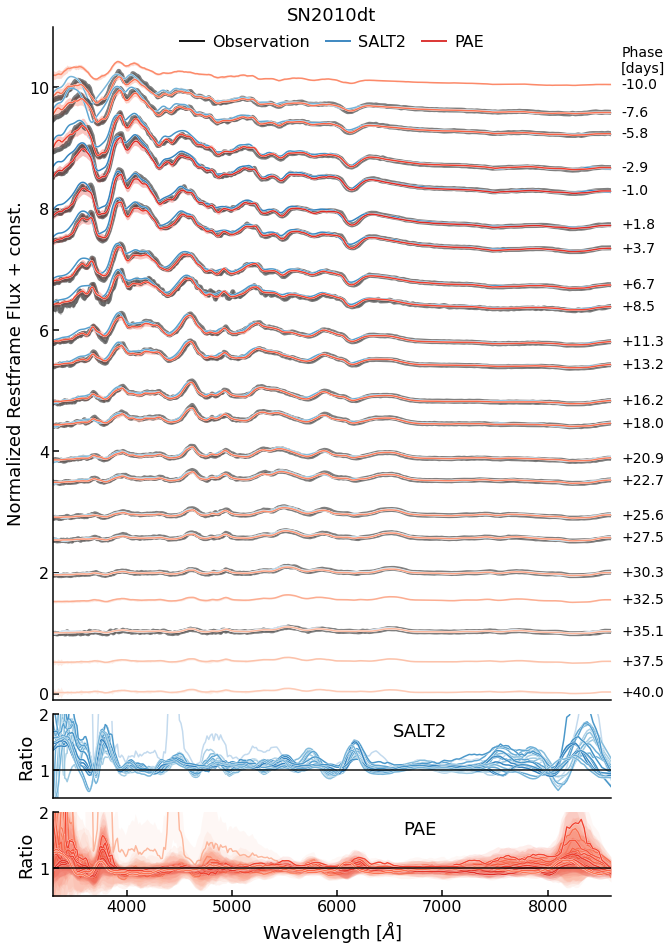

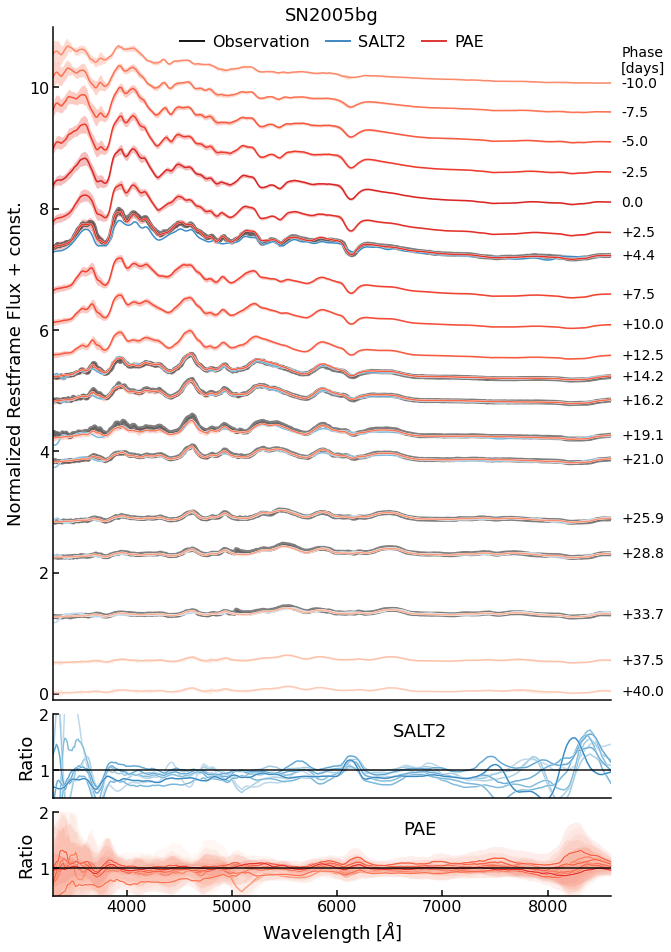

In [10]:
import suPAErnova.utils.calculations as calculations
import matplotlib.patheffects as pe
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from scipy.signal import savgol_filter

ncolor = 256
neg_frac = 0.2 # time ranges from -10 to 40

colors1_salt = plt.cm.Blues(np.linspace(0.4, 0.7, int(ncolor*neg_frac)))
colors2_salt = plt.cm.Blues_r(np.linspace(0.3, 0.8, int(ncolor*(1-neg_frac))))

# combine them and build a new colormap
colors_salt = np.vstack((colors1_salt, colors2_salt))

colors1_pae = plt.cm.Reds(np.linspace(0.4, 0.7, int(ncolor*neg_frac)))
colors2_pae = plt.cm.Reds_r(np.linspace(0.3, 0.8, int(ncolor*(1-neg_frac))))

# combine them and build a new colormap
colors_pae = np.vstack((colors1_pae, colors2_pae))

cmap_salt = LinearSegmentedColormap.from_list('my_colormap', colors_salt)
cmap_pae = LinearSegmentedColormap.from_list('my_colormap', colors_pae)

def plot_spectra_map(data, spec1='salt2',spec2='ae', nshow_interp=26, figsize=(10, 16),
                     lwt=5., lw=1.5, lwpe=2, alpha=1.0, alpha_obs=0.5, alpha_fill=0.3, smooth_bins=7,
                     ispec=0, train=True, savefig=False, tstr='train', relative_error=False):
    
    # Set up plot and aesthetics
    title = data['names'][ispec]
    # Set plot aesthetics                                                                                                 
    aoffsets = [0.4, 0.15, 7]

    cmap = plt.cm.coolwarm
    colors = cmap(np.linspace(0, 1, 256))

    min_sep_interp = 1.5 # minimum seperation of interpolated model and true data, in days
    # c0  = 'C3'
    # c1  = 'C0'
    c0  = colors[int(0.9*len(colors))]
    c1  = colors[int(0.1*len(colors))]    
    
    ### Get data (non-masked spectra)
    spec1 = spec1.upper()
    spec2 = spec2.upper()
    dm = np.max(data['mask'][ispec], axis=-1) != 0.
    x_obs = data['spectra'][ispec, dm].copy()
    
    if spec1=='SALT2':
        x_1 = data['spectra_salt'][ispec, dm].copy()
    if spec1=='AE':
        x_1 = data['spectra_ae'][ispec, dm].copy()
    if spec1=='MAP':
        x_1 = data['spectra_map'][ispec, dm].copy()

    if spec2=='SALT2':
        x_2 = data['spectra_salt'][ispec, dm].copy()
    if spec2=='AE':
        x_2 = data['spectra_ae'][ispec, dm].copy()
    if spec2=='MAP':
        x_2 = data['spectra_map'][ispec, dm].copy()
    if spec2=='PAE':
        x_2 = data['spectra_mcmc'][ispec, dm].copy()

    sigma  = data['sigma'][ispec, dm].copy()
    times_orig  = data['times_orig'][ispec, dm].copy()
    times  = data['times'][ispec, dm].copy()

    wavelengths = data['wavelengths']
    red = data['redshift'][ispec]

    n_spectra = x_obs.shape[0]
    print("Nspectra ", n_spectra)
    
    # get reconstruction uncertainty
    if spec1!="SALT": 
        if spec2=="MAP":
            tuse = times + data['dtime_map'][ispec]
        elif spec2=="PAE":
            tuse = times + data['dtime_mcmc'][ispec]
        else:
            tuse = times
            
        sigma1 = tf.transpose(tfp.math.interp_regular_1d_grid(
                x=tf.transpose(tuse[..., 0]),
                x_ref_min=ae_noise_t_bin_cent[0],
                x_ref_max=ae_noise_t_bin_cent[-1],
                y_ref=data['sigma_ae_time'])) # fill_value='extrapolate')   

    if spec2!="SALT": 
        if spec2=="MAP":
            tuse = times + data['dtime_map'][ispec]
        elif spec2=="PAE":
            tuse = times + data['dtime_mcmc'][ispec]
        else:
            tuse = times
            
        sigma2 = tf.transpose(tfp.math.interp_regular_1d_grid(
                x=tf.transpose(tuse[..., 0]),
                x_ref_min=ae_noise_t_bin_cent[0],
                x_ref_max=ae_noise_t_bin_cent[-1],
                y_ref=data['sigma_ae_time'])) # fill_value='extrapolate')   


    # Turn off axis lines
#         ax1.set_frame_on(False)
#         ax1.get_xaxis().tick_bottom()
#         ax1.axes.get_yaxis().set_visible(False)
#         xmin, xmax = ax1.get_xaxis().get_view_interval()
#         ymin, ymax = ax1.get_yaxis().get_view_interval()
#         ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

    # set constant offset scale
    #         offset = np.arange(len(times)) * -1 * aoffsets[iplt]
    wave_txt = wavelengths[-1]+100
    
    fontsize = 14
    
    offset_scale = 10
    
    offset = -times * offset_scale + offset_scale

    phase_text_loc = offset_scale+0.2
    
    ymin = -0.1
    ymax = offset_scale + 1.0
    # Plot spectra 1 by 1
    toffset_min = 0.3
  
    toffset_prev = 0.0

    ind_tmax = np.argmin(times_orig[:n_spectra])
    
    # Get interpolated model predictions at specified times
    # First get spectra from latent variables at linear spaced times between -10 and 40
    times_interp = np.zeros((1, params['n_timestep'])).astype(np.float32) 
    times_interp[:, :nshow_interp] = np.linspace(0, 1, nshow_interp)
    mask_interp    = np.ones((1, params['n_timestep'], 288))
    mask_interp[:, nshow_interp:] = 0
    offset_interp = -times_interp * offset_scale + offset_scale

    times_orig_interp = times_interp*50 - 10
    # times_interp[0,0] += 1./50
    # times_interp[0, nshow_interp-1] -= 1./50

    spectra_interp = PAE.decoder((data['z_latent_mcmc'][ispec:ispec+1], times_interp, mask_interp))[0] 

    dm = mask_interp[0, ..., 0] == 1
    dm_time = [np.min(np.abs(times_orig[:, 0] - i)) > min_sep_interp for i in times_orig_interp[0]] # remove closer than this to observed spectra
    dm = dm & dm_time

    spectra_interp = spectra_interp[dm]
    times_interp = times_interp[0, dm]
    times_orig_interp = times_orig_interp[0, dm]
    offset_interp = offset_interp[0, dm]

    sigma_interp = tf.transpose(
        tfp.math.interp_regular_1d_grid(
            x=tf.transpose(times_interp),
            x_ref_min=ae_noise_t_bin_cent[0],
            x_ref_max=ae_noise_t_bin_cent[-1],
            y_ref=data['sigma_ae_time'],
        ),
    ) # fill_value='extrapolate')   

    fig, axs = plt.subplots(
        nrows=3, ncols=1, figsize=figsize,
        gridspec_kw={'height_ratios': [8, 1, 1]},
    )                                  
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for ax in axs:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.5)

        ax.tick_params('both', length=6, width=1.5, which='major', color='k',direction='in')
        ax.tick_params('both', length=3, width=1.5, which='minor', color='k',direction='in')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
        ax.set_xlim(wavelengths[0], wavelengths[-1])

    axs[0].get_xaxis().set_ticks([])
    axs[1].get_xaxis().set_ticks([])

    axs[0].set_ylabel('Normalized Restframe Flux + const.') 
    axs[1].set_ylabel('Ratio')
    axs[2].set_ylabel('Ratio')
    axs[2].set_xlabel('Wavelength [$\AA$]')

    axs[0].set_title(title, fontsize=18)   
    
    # Plot interpolated model spectra
    for i in range(spectra_interp.shape[0]):
        c0 = cmap_pae(times_interp[i])

        xi = spectra_interp[i] + offset_interp[i]
        axs[0].fill_between(
            wavelengths,
            xi - spectra_interp[i]*sigma_interp[i],  
            xi + spectra_interp[i]*sigma_interp[i],
            color=c0, alpha=alpha_fill, lw=0)
           

        axs[0].plot(wavelengths, spectra_interp[i] + offset_interp[i], '-', c=c0, lw=lw, alpha=alpha)#,

        phase_label = f"+{times_orig_interp[i]:.1f}" if times_orig_interp[i] > 0 else f"{times_orig_interp[i]:.1f}"
        axs[0].text(wave_txt, offset_interp[i]+(xi[-1]-offset_interp[i]), phase_label, fontsize=fontsize, ha='left', va='center')

    # Plot observations and matching models
           
    axs[0].plot(wavelengths, wavelengths*-10, lw=2, color= 'k', alpha=0.9, label="Observation")
    axs[0].plot(wavelengths, wavelengths*-10, lw=2, color= cmap_salt(0.2), alpha=0.9, label="SALT2")
    axs[0].plot(wavelengths, wavelengths*-10, lw=2, color= cmap_pae(0.2), alpha=0.9, label="PAE")

    for i in range(n_spectra):
        
        if i > 0 and abs(times_orig[i][0]-times_orig[i-1][0]) < 0.5:
            # Don't plot spectra that are on top of each other
            continue
        c1 = cmap_salt(times[i][0])
        c0 = cmap_pae(times[i][0])
        
        labp = None
        labs = None
        labo = None
        ls= '-'

        toffset_i = offset[i]
        dt_add = 0
        if np.abs(toffset_i - toffset_prev) < toffset_min and i >0:
            dt_add = np.abs(toffset_i - toffset_prev)-toffset_min


        xi = x_obs[i] + offset[i]
        x1i = x_1[i] + offset[i]
        x2i = x_2[i] + offset[i]

        #### Plot top panel (spectra)
        axs[0].plot(wavelengths, xi, '-', c='k', lw=lwt, alpha=alpha_obs, label=labo)#colors[i])                       
        axs[0].fill_between(wavelengths, xi-sigma[i],  xi+sigma[i], color='gray', alpha=alpha_fill, lw=1)

        if spec1!="SALT2": 
            if relative_error:
                axs[0].fill_between(wavelengths, x1i-x_1[i]*sigma1[i],  x1i+x_2[i]*sigma1[i], color=c1, alpha=alpha_fill, lw=0)
            else:
                axs[0].fill_between(wavelengths, x1i-sigma1[i],  x1i+sigma1[i], color=c1, alpha=alpha_fill, lw=0)

        if spec2!="SALT2": 
            if relative_error:
                axs[0].fill_between(wavelengths, x2i-x_2[i]*sigma2[i],  x2i+x_2[i]*sigma2[i], color=c0, alpha=alpha_fill, lw=0)
            else:
                axs[0].fill_between(wavelengths, x2i-sigma2[i],  x2i+sigma2[i], color=c0, alpha=alpha_fill, lw=0)

        axs[0].plot(wavelengths, x1i, '-', c=c1, lw=lw, alpha=alpha, label=labs,
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])
        axs[0].plot(wavelengths, x2i, ls=ls, c=c0, lw=lw, alpha=alpha, label=labp,
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])

        #### Plot bottom ratio panel
        # axs[1].plot(wavelengths, xi*0+1, '-', c='k', lw=lwt, alpha=0.8, label=labo)#colors[i])                       
        # axs[1].fill_between(wavelengths, (x_obs[i]-sigma[i])/x_obs[i],  (x_obs[i]+sigma[i])/x_obs[i], color='gray', alpha=0.8, lw=1)

        if spec1!="SALT2": 
            if relative_error:
                axs[1].fill_between(
                    wavelengths,
                    (x_1[i]-x_1[i]*sigma1[i])/x_obs[i],
                    (x_1[i]+x_1[i]*sigma1[i])/x_obs[i],
                    color=c1,
                    alpha=alpha_fill,
                    lw=0,
                    zorder=-abs(ind_tmax - i),
                )
            else:
                axs[1].fill_between(wavelengths, x1i-sigma1[i],  x1i+sigma1[i], color=c1, alpha=alpha_fill, lw=0)

        if spec2!="SALT2": 
            l = (x_2[i]+x_2[i]*sigma1[i])/x_obs[i]
            u = (x_2[i]-x_2[i]*sigma1[i])/x_obs[i]
            
            l = savgol_filter(l, smooth_bins, 1)
            u = savgol_filter(u, smooth_bins, 1)
                    
            if relative_error:
                axs[2].fill_between(
                    wavelengths,
                    l,
                    u,
                    color=c0,
                    alpha=0.1,
                    lw=0,
                    zorder=-abs(ind_tmax - i),
                )
            else:
                axs[2].fill_between(wavelengths, x2i-sigma2[i],  x2i+sigma2[i], color=c0, alpha=alpha_fill, lw=0)

        sig1 = x_1[i]/x_obs[i]
        sig2 = x_2[i]/x_obs[i]
        
        # sig1 = np.abs(x_1[i]-x_obs[i])/sigma[i]
        # sig2 = np.abs(x_2[i]-x_obs[i])/sigma[i]

#         resid1 = np.abs(x_1[i] - x_obs[i])
#         sig1 = np.zeros(resid1.shape[0])
#         mask = resid1**2 > sigma[i]**2
#         sig1[mask] = frac_to_mag(np.sqrt(resid1[mask]**2 - sigma[i][mask]**2))
    
#         resid2 = np.abs(x_2[i] - x_obs[i])
#         sig2 = np.zeros(resid2.shape[0])
#         mask = resid2**2 > sigma[i]**2
#         sig2[mask] = frac_to_mag(np.sqrt(resid2[mask]**2 - sigma[i][mask]**2))
    
        sig1 = savgol_filter(sig1, smooth_bins, 1)
        sig2 = savgol_filter(sig2, smooth_bins, 1)
        
        axs[1].plot(wavelengths, sig1, '-', c=c1, lw=lw, alpha=alpha, label=labs, zorder=-abs(ind_tmax - i),
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])
        axs[2].plot(wavelengths, sig2, ls=ls, c=c0, lw=lw, alpha=alpha, label=labp, zorder=-abs(ind_tmax - i),
                path_effects=[pe.Stroke(linewidth=lwpe, foreground='w'), pe.Normal()])        
        

        # add phase in days
        if i==0:
            axs[0].text(wave_txt+200, phase_text_loc, 'Phase\n[days]', fontsize=fontsize, ha='center', va='bottom')

        phase_label = f"+{times_orig[i][0]:.1f}" if times_orig[i][0] > 0 else f"{times_orig[i][0]:.1f}"
        axs[0].text(wave_txt, offset[i]+(xi[-1]-offset[i])+dt_add, phase_label, fontsize=fontsize, ha='left', va='center')

        # ymin = min(ymin, min(xi), min(x1i), min(x2i) )
        # ymax = max(ymax, max(xi), max(x1i), max(x2i) )

    axs[1].plot(wavelengths, xi*0+1, '-', c='k', lw=2, alpha=0.7, label=labo)#colors[i])                       
    axs[2].plot(wavelengths, xi*0+1, '-', c='k', lw=2, alpha=0.7, label=labo)#colors[i])   
    
    axs[1].text(wavelengths[int(len(wavelengths)*3/4)], 1.6, "SALT2", ha='center')
    axs[2].text(wavelengths[int(len(wavelengths)*3/4)], 1.6, "PAE", ha='center')

    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.01),
               frameon=False, ncol=3, columnspacing=1., handletextpad=0.5, handlelength=1.5)

    axs[0].set_ylim(ymin, ymax)
    axs[1].set_ylim(0.5, 2.0)
    axs[2].set_ylim(0.5, 2.0)

    # axs[1].set_yscale('log')

    toffset_prev = offset[i]

    if savefig:
        # plt.savefig('../figures/spectra_fit_{:02d}latentdim_{:s}_{:s}_{:s}_{:s}_{:03d}.pdf'.format(latent_dim, plttype, tstr, spec1.upper(), spec2.upper(), ispec), bbox_inches='tight')
        plt.savefig('../figures/spectra_fit_{:02d}latentdim_{:s}_{:s}_{:s}_{:03d}.pdf'.format(latent_dim, tstr, spec1.upper(), spec2.upper(), ispec), bbox_inches='tight')



dm = (test_data['redshift'] > params['min_train_redshift']) & \
             (test_data['redshift'] < params['max_train_redshift'])

test_data['sigma_ae_time'], ae_noise_t_bin_edge, ae_noise_t_bin_cent = calculations.compute_sigma_ae_time(test_data['spectra'][dm],
                                                                                            np.clip(test_data['spectra_mcmc'][dm], 0, np.inf),
                                                                                            test_data['sigma'][dm],
                                                                                            test_data['times'][dm],
                                                                                            test_data['mask'][dm])
# savefig = False
savefig = True

nshow_interp = 21 #3

istart = 0 #ind_max #4 #44
nplt = 20
# plts = [88,9]
plts = [ 11,  40,  51,  61,  63, 105, 109, 123, 131] # ones not near peak

# for iplt in range(istart, istart+nplt):

inds = np.argsort(test_data['mask'].sum(1)[:, 0])#[::-1]

# for iplt in inds[dm[inds]][istart:istart+nplt]: 
for iplt in [2, 38]: 
# for iplt in [108, 143, 102, 164]:
# for iplt in [102]:#2,6, 38, 43]: 
# for iplt in [30, 24]:#2,6, 38, 43]: 
# for iplt in [38]: 

    print(iplt)

    carr = np.arange(train_data['z_samples'][:, iplt].shape[-2])

    latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
    labels = ['$\Delta t$', '$\Delta m$', '$\Delta A_V$'] + latent
    
    # plot_spectra_map(train_data, ispec=iplt, nshow_interp=nshow_interp, spec1='salt2', spec2='pae', train=True, 
    #                  savefig=savefig, tstr='train', relative_error=True)
    
    plot_spectra_map(test_data, ispec=iplt, nshow_interp=nshow_interp, spec1='salt2', spec2='pae', train=False, 
                     savefig=savefig, tstr='test', relative_error=True)


<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)
<ipython-input-8-5b6d51f3657e>:11: RuntimeWarning: invalid value encountered in log10
  neg_mag = 2.5 * np.log10(1. - fractional_difference)


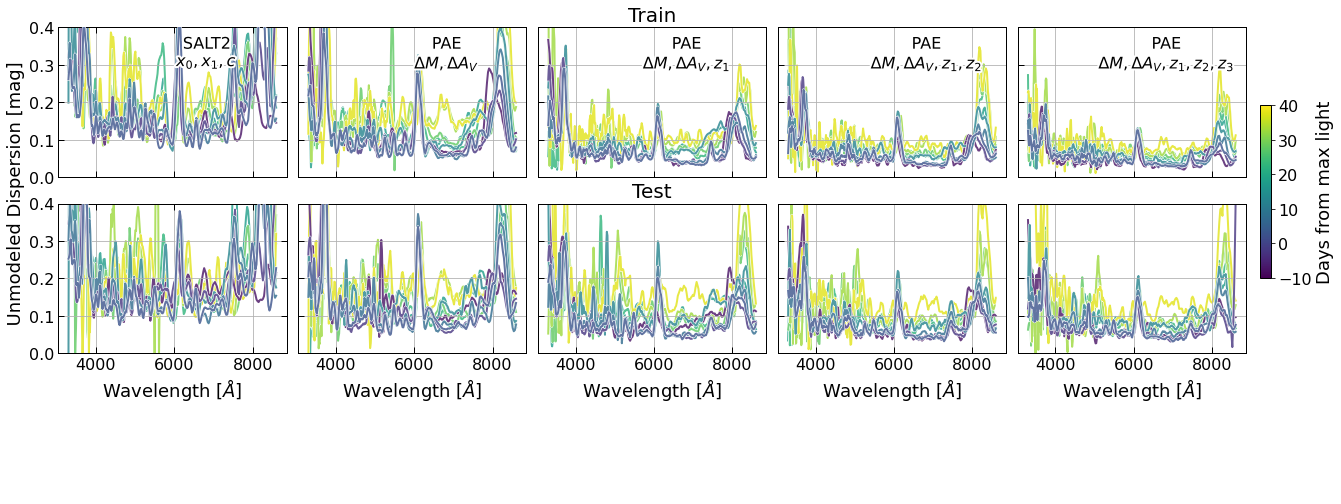

In [14]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from scipy.signal import savgol_filter

np.seterr(divide = 'ignore') 

# Simulate data
# When we quote an "intrinsic dispersion", what we are measuring is the additional dispersion that you need to explain the observed variance in your data.

# Assume that you have a data flux f, a model flux m, measurement uncertainties sigma_f, and you want to measure an intrinsic dispersion sigma_i. Then the statistical model is:

# f ~ N(m, sigma_f^2 + sigma_i^2)

# We fit for the maximum likelihood estimate of sigma_i. This is roughly equivalent to "picking the value of sigma_i that sets the chi2/DoF to 1". Here's a demo of how to do this in Python:
# Our model is a bit more complicated because we use a Gaussian process, but it's doing something similar under the hood. We do this for each wavelength separately.

ncolor = 256
neg_frac = 0.2 # time ranges from -10 to 40
# colors1 = plt.cm.Blues(np.linspace(0.2, 1, int(ncolor*neg_frac)))
# colors2 = plt.cm.Oranges_r(np.linspace(0, 0.8, int(ncolor*(1-neg_frac))))

# colors1 = plt.cm.Blues_r(np.linspace(0., 0.8, int(ncolor*neg_frac)))
# colors2 = plt.cm.Oranges(np.linspace(0.2, 1.0, int(ncolor*(1-neg_frac))))

# colors1 = plt.cm.hot(np.linspace(0.0, 0.4, int(ncolor*neg_frac)))
# colors2 = plt.cm.hot(np.linspace(0.4, 0.7, int(ncolor*(1-neg_frac))))
colors1 = plt.cm.coolwarm_r(np.linspace(0.5, 1.0, int(ncolor*neg_frac))[::-1])
colors2 = plt.cm.coolwarm_r(np.linspace(0.0, 0.5, int(ncolor*(1-neg_frac)))[::-1])
# colors1 = plt.cm.Spectral(np.linspace(0.0, 0.5, int(ncolor*neg_frac)))
# colors2 = plt.cm.Spectral(np.linspace(0.5, 1.0, int(ncolor*(1-neg_frac))))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
# cmap = LinearSegmentedColormap.from_list('my_colormap', colors)
# cmap = plt.cm.cividis

# cmap = plt.cm.turbo
# cmap = plt.cm.viridis
# cmap = plt.cm.Spectral_r

# intrinsic_dispersion = 0.1
# N = 200
# measurement_uncertainties = np.random.uniform(0.05, 0.1, N)
# residuals = np.random.normal(0, np.sqrt(measurement_uncertainties**2 + intrinsic_dispersion**2), N)

# # Fit for the intrinsic dispersion
# def gaussian_likelihood(residuals, measurement_uncertainties, intrinsic_dispersion):
#     variance = measurement_uncertainties**2 + intrinsic_dispersion**2
#     return 1 / np.sqrt(2 * np.pi * variance) * np.exp(-residuals**2 / 2 / variance)

# def negative_log_likelihood(x):
#     likelihoods = gaussian_likelihood(residuals, measurement_uncertainties, x[0])
#     return -np.sum(np.log(likelihoods))

# from scipy.optimize import minimize
# res = minimize(negative_log_likelihood, [0.05])

# print(f"Recovered intrinsic dispersion: {res.x[0]}")



# latent_dims = [1,2,3,4] # 3, 4, 5, 6, 7]
latent_dims = [-1, 0, 1, 2, 3]#-1,0,1,2,3]

savefig = True
# savefig = False

smooth_bins=7

# tstr = 'test'
tstrs = ['train', 'test']
# tstrs = ['train']
# tstrs = ['test']

# file_string = 'test'

# file_string = 'layers256-128-32_minz_0pt02_data_augment_decorrelatedust'
# file_string = 'layers256-128-32_minz_0pt02_dtimecorrect'#_longchain_Avvary'
# file_string = 'layers256-128-32_3stage_train_decorrelate_all'#_longchain_Avvary'

# file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0' #_magnitude_nosig'
file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"#_nosigmaweight_smallcov"

params['min_train_redshift'] = 0.02
params['max_train_redshift'] = 1.00
params['max_light_cut'] = [-10, 40]
params['twins_cut'] = False


fig, axss = plt.subplots(nrows=2, ncols=len(latent_dims),
                        sharey=True, figsize=(4*len(latent_dims), 6), squeeze=False)#, gridspec_kw={'height_ratios': [3, 1]})
  
fig.subplots_adjust(wspace=0.05, hspace=0.175)
    
for itstr, tstr in enumerate(tstrs):

    axs = axss[itstr]                 

    # Make dummie mappable
    xx = np.linspace(-10, 40, 100)
    dummie_cax = axs[0].scatter(xx, xx, c=xx, cmap=cmap)
    # Clear axis
    axs[0].cla()

    for ax in axs:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.)

        ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
        ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')


        ax.set_ylim(0, 0.4)

        ax.set_yscale('linear')

        ax.grid()
        
        if itstr == 1:
            ax.set_xlabel('Wavelength [$\AA$]')

        if itstr == 0:
            ax.set_xticklabels([])

    if itstr==1:
        axs[0].set_ylabel('                              Unmodeled Dispersion [mag]')

    
    for il, latent_dim in enumerate(latent_dims):
        
        if il == 2:
            axs[il].set_title(tstr.capitalize(), fontsize=20)

        if itstr == 0:

            if latent_dim < 0:
                latent_str = "SALT2\n"+r"$x_0, x_1, c$" 
            else:
                latent_str = "PAE\n"+r"$\Delta M, \Delta A_V" 
                if latent_dim > 0:
                    for idim in range(latent_dim):
                        latent_str += r", z_{:d}".format(idim+1)
                latent_str+="$"
            axs[il].text(train_data['wavelengths'][-70], 0.375,
                         latent_str, fontsize=16, ha='center', va='top',
                            path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()], zorder=100)

#         if latent_dim == 3 or latent_dim==-1:
#             file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"
#             print(file_string)
#             train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, 3, file_string)
#             test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, 3, file_string)

#         else:

#             file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"
#             print(file_string)
#             train_data_file = '../outputs/old/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
#             test_data_file  = '../outputs/old/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
            
        latent_dim_load = latent_dim
        if latent_dim_load < 0:
            latent_dim_load = 3
            
        if latent_dim_load == 3:
            train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim_load, file_string)
            test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim_load, file_string)
        else:
            train_data_file = '../outputs/pre_wavelength_mask/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim_load, file_string)
            test_data_file  = '../outputs/pre_wavelength_mask/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim_load, file_string)
            
            train_mask_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, 3, file_string)
            test_mask_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, 3, file_string)
            
            train_data_mask = load_data(train_mask_data_file)
            test_data_mask = load_data(test_mask_data_file)

    #     train_data['spectra_ae'] = np.clip(train_data['spectra_ae'], 0., np.inf)
    #     test_data['spectra_ae'] = np.clip(test_data['spectra_ae'], 0., np.inf)

        if tstr == 'train':
            train_data = load_data(train_data_file)
            data = train_data
            if latent_dim_load != 3:
                data_mask = train_data_mask
            else:
                data_mask = data
        if tstr == 'test':
            test_data = load_data(test_data_file)
            data = test_data
            if latent_dim_load != 3:
                data_mask = test_data_mask
            else: 
                data_mask = data
        # from scipy.optimize import minimize
        # res = minimize(negative_log_likelihood, [0.05])

        # print(f"Recovered intrinsic dispersion: {res.x[0]}")

        dm = get_train_mask(data, params)

        #         dm_redshift = (data['redshifts'] > min_train_redshift) & \
        #                       (data['redshifts'] < max_train_redshift)

        if latent_dim < 0:
            t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_salt'][dm], data['sigma'][dm], data_mask['mask'][dm], data['times'][dm])
        else: 
            # t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_ae'][dm], data['sigma'][dm], data['times'][dm])
            t_bin_cent, mean_spectra, measurement_dispersion, intrinsic_dispersion = compute_intrinsic_dispersion_vs_time(data['spectra'][dm], data['spectra_mcmc'][dm], data['sigma'][dm], data_mask['mask'][dm], data['times'][dm])

        zorders = [1,2,3,2,1,0,0,0,0,0,0]
        alpha = 0.9
        lw = 3

        # rms = -2.5*np.log10((mean_spectra)/(mean_spectra+intrinsic_dispersion))
        # rms = 2.5*np.log10((mean_spectra+intrinsic_dispersion)/(mean_spectra))
        rms = frac_to_mag(intrinsic_dispersion/mean_spectra)

        for it in range(t_bin_cent.shape[0]):
            rmsi = savgol_filter(rms[it], smooth_bins, 2)


            axs[il].plot(train_data['wavelengths'], rmsi, '-',
                    path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()],
                    c=cmap_scatter(t_bin_cent[it]), 
    #                 lw=lw-abs(0.2-t_bin_cent[it]*2), 
    #                 alpha=alpha-abs(0.2-t_bin_cent[it]/2), 
                    lw=2, 
                    alpha=0.8, 
                    zorder=zorders[it])#, label='MAP')

        # ax1.set_title('SALT2', fontsize=16)

fig.subplots_adjust(right=0.95)
cax = fig.add_axes([0.96, 0.3, 0.0075, 0.4])
fig.colorbar(dummie_cax, cax=cax, label='Days from max light')

if savefig: 
    fname = 'rmse_train_test_all_dim'
    plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')


# Visualize spectral effects of varying model parameters

[[0.02 0.2  0.4  0.6  0.8  0.98 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]] [[-10.   0.  10.  20.  30.  40. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
  -10. -10. -10. -10.]]
[[-0.00094667 -0.01553152 -0.01047225 -0.09186259 -0.01232488  0.00551432]] (1, 6) (9, 4)


No handles with labels found to put in legend.
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


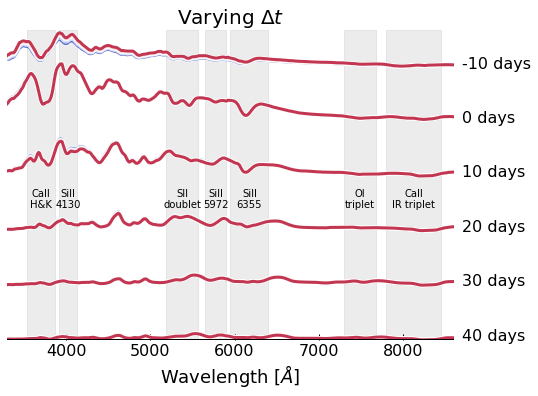

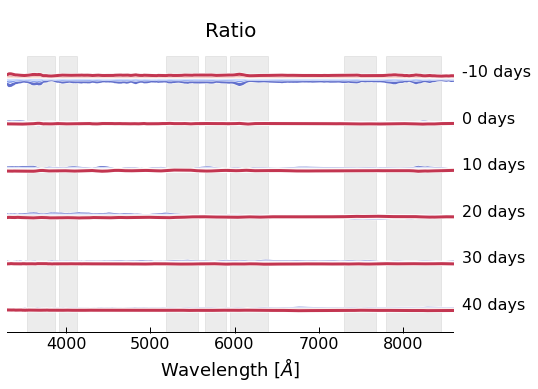

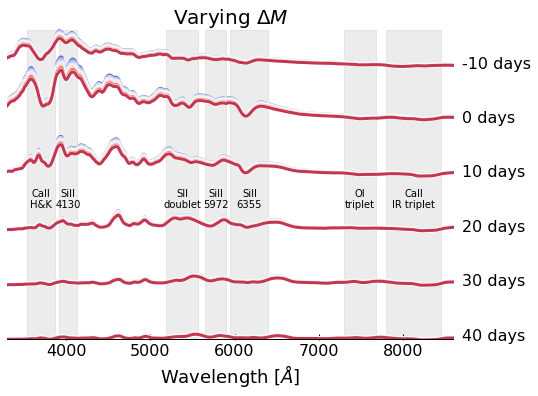

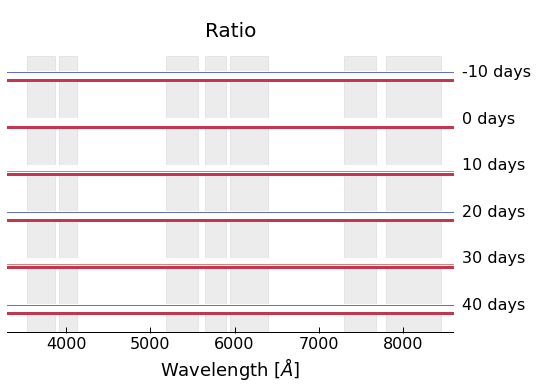

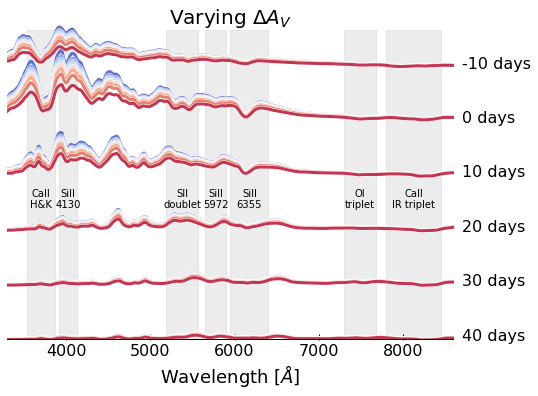

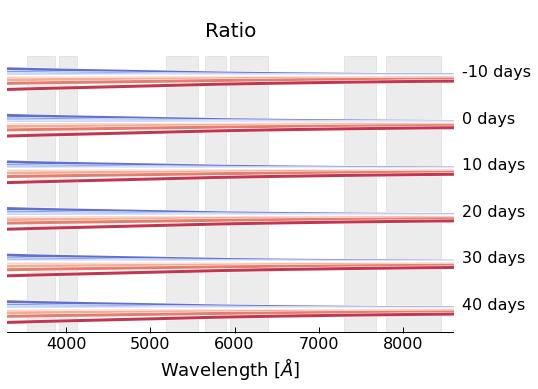

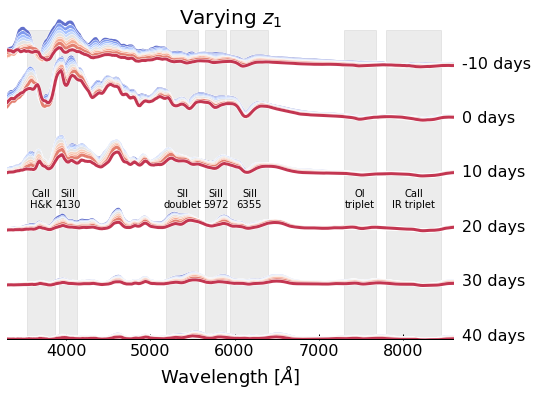

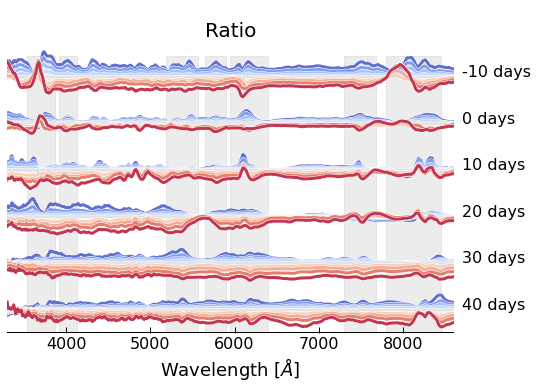

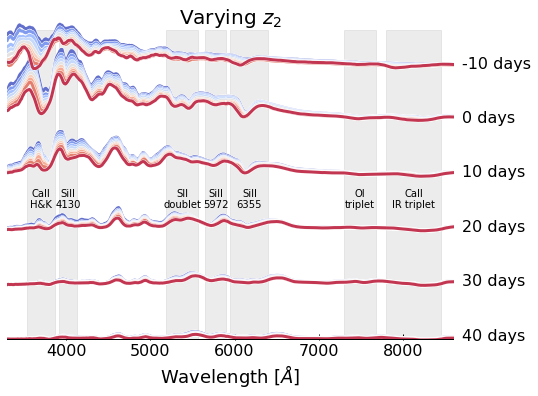

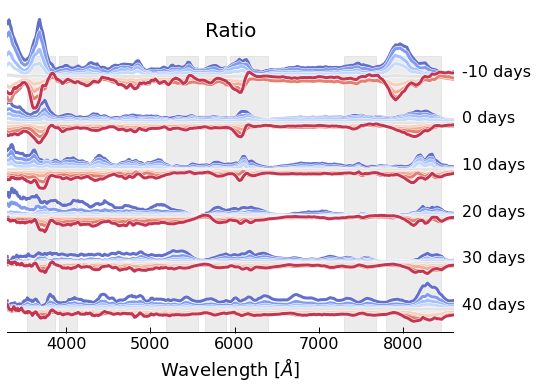

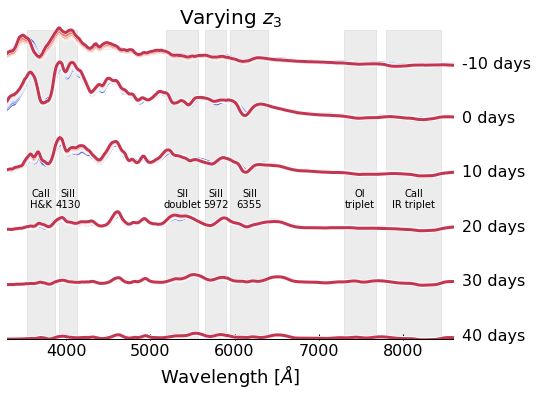

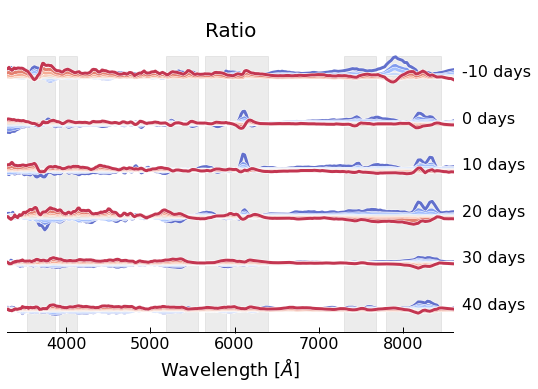

In [18]:
import matplotlib.patheffects as pe

# Plot SN while varying z latent params to see effects

savefig = True
# savefig = False

figdir = '../figures/'

# Set up figure aesthetics
latent = ['$z_{:d}$'.format(i+1) for i in range(train_data['z_latent'].shape[1]-3)]
labels = ['$\Delta t$', '$\Delta M$', '$\Delta A_V$'] + latent

plot_line_labels = True

label_lines = {
    'SiII\n4130': (3920, 4130),
    'SiII\n5972': (5650, 5900),
    'SiII\n6355': (5950, 6400),
    'CaII\nH&K': (3530, 3870),
    'CaII\nIR triplet': (7800, 8450),
    'SII\ndoublet': (5180, 5570),
    'OI\ntriplet': (7300, 7680),
}

lwt = 2
lw  = 3

c0  = 'orangered'
c1  = 'C0'

dim_plus_2 = 1 #2

wave_txt = train_data['wavelengths'][-1]+100

alpha=0.8
plttypes = ['normal', 'residual']
aoffsets_list = [[0.1, 3], [0.1, 5], [1.5, 2.75]] #0.7]

# Get observation times and bin latent params
dm = get_train_mask(train_data, params)
z_latent_use = train_data['z_latent_mcmc']

nsamples = 10
percentiles = np.arange(10, 100, nsamples)
z_bin_edge = np.percentile(z_latent_use, percentiles, axis=0)
nsamples = z_bin_edge.shape[0]

Asamp = np.linspace(0.5, 1.5, nsamples)

nshow = 6 #3
times_lin = np.zeros((1, params['n_timestep'])) 
times_lin[:, :nshow] = np.linspace(0,1,nshow)
mask_     = np.ones((1, params['n_timestep'], 288))

times_orig_lin = times_lin*50 - 10
times_lin[0,0] += 1./50
times_lin[0,nshow-1] -= 1./50

print(times_lin, times_orig_lin)

# cmap = plt.cm.coolwarm
colors = cmap_spectra(np.linspace(0,1,nsamples))

z_median = np.median(z_latent_use[dm], axis=0)[None, ...]

# get u array of zeros
print(z_median, z_median.shape, colors.shape)

for dim in range(z_bin_edge.shape[1]):

    aoffsets = [0.75, 1.5]
    zsamp = z_bin_edge[:, dim]

    for iplt, plttype in enumerate(plttypes):
        
        if plttype == 'normal':   title = 'Varying {:s}'.format(labels[dim])
        if plttype == 'residual': title = 'Ratio'

        fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))#, gridspec_kw={'height_ratios': [3, 1]})

        for axis in ['top','bottom','left','right']:
            ax1.spines[axis].set_linewidth(1.)

        ax1.tick_params('both', length=6, width=1., which='major', color='k',direction='in')                                         
        ax1.tick_params('both', length=3, width=1., which='minor', color='k',direction='in')

        ymin = 100
        ymax = -100
        
        # get origin value
        z_ = z_median.copy()
        xpred_m = PAE.decoder((z_, times_lin,  mask_))[0]
        
        offset = np.arange(times_lin.shape[1]) * -1 * aoffsets[iplt]
        
        for sample in range(z_bin_edge.shape[0]):

            # set u values along slice
            z_ = z_median.copy()
            z_[:, dim:dim+dim_plus_2] = zsamp[sample]

            xpred_i = PAE.decoder((z_, times_lin, mask_))[0] #/ (10**(-0.4* (CL*np.exp(z_[:, -1]) + z_[:, 0])))

            for i in range(nshow):
                labp = None
                labo = None
                if i==0:
                    labs = 'Encoder'
                    labp = 'MAP'
                if plttype == 'normal':
                    xpi = xpred_i[i] + offset[i]
                    ax1.plot(train_data['wavelengths'], xpi, '-',
                             c=colors[sample], lw=lw, alpha=alpha,
                            path_effects=[pe.Stroke(linewidth=lw+1, foreground='w'), pe.Normal()],
                            )#, label=labp)

                    if sample == len(zsamp)//2:
                        ax1.text(wave_txt, offset[i], '{:.0f} days'.format(times_orig_lin[0,i]), fontsize=16)

                    ymin = min(ymin, min(xpi) )
                    ymax = max(ymax, max(xpi) )

                if plttype == 'residual':
                    xti = xpred_m[i]
                    xpi = xpred_i[i]
                    ax1.plot(train_data['wavelengths'], xpi/xti - 1 + offset[i],
                             '-', c=colors[sample], lw=lw, alpha=alpha,
                            path_effects=[pe.Stroke(linewidth=lw+1, foreground='w'), pe.Normal()],
                            )#, label=labp)

                    if sample == len(zsamp)//2:
                        ax1.text(wave_txt, (xpi/xti)[-1] - 1 + offset[i], '{:.0f} days'.format(times_orig_lin[0,i]), fontsize=16)
                
                    ymin = min(ymin, min(xpi/xti -1 + offset[i]) )
                    ymax = max(ymax, max(xpi/xti -1 + offset[i]) )

        if plot_line_labels:
            if plttype == 'residual':
                ymax_line_labels = 0.85
            if plttype == 'normal':
                ymax_line_labels = 0.95

            for line_label, (min_wave, max_wave) in label_lines.items():
                ax1.axvspan(min_wave, max_wave, alpha=0.15, ymax=ymax_line_labels, color='gray')
                if plttype == 'normal':
                    # display text
                    mean_wave = (min_wave + max_wave) / 2.
                    ax1.text(mean_wave, -aoffsets[iplt]*2.6, line_label, fontsize=10.,
                             horizontalalignment='center', verticalalignment='bottom')


        ax1.set_ylabel('Restframe Flux')
        ax1.set_xlabel('Wavelength [$\AA$]')
        ax1.set_ylabel('Normalized Restframe Flux(t, $\lambda$)')

        if plttype == 'normal':
            ymax = offset[0] + aoffsets[iplt] 
            ymin = offset[nshow-1]
            ax1.set_title(title, fontsize=20, y=0.97, pad=0)

        if plttype == 'residual':
            # ymax = ymax+0.5
            # ymin = ymin-0.5
            ymax = offset[0] + aoffsets[iplt] * 1.5
            ymin = offset[nshow-1] - aoffsets[iplt]*1./2
            ax1.set_title(title, fontsize=20, y=0.91, pad=0)

        ax1.set_ylim(ymin, ymax)
        ax1.set_frame_on(False)
        ax1.get_xaxis().tick_bottom()
        ax1.axes.get_yaxis().set_visible(False)
        xmin, xmax = ax1.get_xaxis().get_view_interval()
        ymin, ymax = ax1.get_yaxis().get_view_interval()
        ax1.add_artist(plt.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

        ax1.legend(loc='upper right', frameon=False, ncol=3)


    #     ax1.axis('off')

    #     ax2.set_yscale('log')
        ax1.set_xlim(train_data['wavelengths'][0], train_data['wavelengths'][-1])
    #     plt.subplots_adjust(hspace=0.025)

        if savefig: 
            fname = 'vary_zlatent_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)
            if dim_plus_2 > 1:
                fname = 'vary_zlatent_dimplus2_{:02d}Dlatent_dim{:d}_{:s}'.format(latent_dim, dim, plttype)

            plt.savefig(figdir+fname+'.pdf', bbox_inches='tight')



# Magnitude residuals vs other techniques

In [19]:
import pandas as pd
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

In [79]:
# Construct PAE/salt2/twins table

import pandas as pd

df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 3
kfold = 0

maxlightcut_str = ''

file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

file_string = "layers256-128-32_3stage_train_decorrelate_all"

tstrs = ['train', 'test']
# tstrs = ['test']

seeds_use = np.array([0, 1, 2, 3, 4, 5, 6, 7])#, 8, 9])

df = None
for ti, tstr in enumerate(tstrs):
    
    if tstr=='train':
        data = train_data

        m = '*'
#         dm = np.full(train_data['maximum_likelihood'].shape[0], True, dtype=bool)
#         dm = train_data['maximum_likelihood'] > test_data['maximum_likelihood']

    if tstr=='test':
        m = '*'
        data = test_data

    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    xi1_twins = np.zeros(data['redshift'].shape[0])
    xi2_twins = np.zeros(data['redshift'].shape[0])
    xi3_twins = np.zeros(data['redshift'].shape[0])

    
    c_salt = data['c']
    x1_salt = data['x1']

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
        xi1_twins[ind_snf] = dfi['xi_1']
        xi2_twins[ind_snf] = dfi['xi_2']
        xi3_twins[ind_snf] = dfi['xi_3']

    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift) & \
                    (np.sum(data['mask'], axis=(1,2)) > 0)

    
    # Dl = c*z/H0
    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err to get new redshift      

    dl = z #(1+z)*z
    dl1 = z1 #(1+z1)*z1 # don't need leading constant c/H0
    
    # mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05
    mag_err_vel = abs(-5*np.log10(dl/dl1)) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]

    mask_grid = in_twins
    # mask_grid = mask_twins
    # mask_grid = dm_redshift & mask_grid

    for iseed, seed in enumerate(seeds_use):
        data_filei = f'../outputs/{tstr}_data_kfold{kfold}_posterior_{latent_dim:02d}Dlatent_{file_string}_seed{seed}{maxlightcut_str}.npy'
        datai = load_data(data_filei)

        if iseed == 0:
            A = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))
            A_err = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))

        A[iseed] = datai['amplitude_mcmc']
        A_err[iseed] = np.sqrt(datai['amplitude_mcmc_err']**2)# + mag_err_vel**2)

        
        
    # http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf
    weight = 1./A_err**2
    n_eff = np.sum(weight*A, axis=0)**2/np.sum(weight**2, axis=0)

    # A_mean = A.mean(0)
    weighted_mean = np.sum(weight*A, axis=0)/np.sum(weight, axis=0)

    weighted_deviation  = np.sqrt(A.shape[0]/(A.shape[0] - 1) *  
                            ( np.sum(weight*A**2, axis=0)/np.sum(weight, axis=0) - weighted_mean**2))

    weighted_err = weighted_deviation #/np.sqrt(A.shape[0])
    weighted_err = np.sqrt(weighted_err**2 + mag_err_vel**2)

    dfi = pd.DataFrame({
        'name': data['names'][in_twins],
        'redshift': data['redshift'][in_twins],
        'in_twins_final_analysis': mask_twins[in_twins]*1,
        'in_train_set': np.array([tstr == 'train']*len(mask_twins[in_twins]))*1,
        
        # 'dm_pae': data['z_latent_mcmc'][in_twins, 1],
        'dm_pae': weighted_mean[in_twins],
        'd_dm_pae': weighted_deviation[in_twins],
        
        'dp_pae': data['z_latent_mcmc'][in_twins, 0],
        'dav_pae': data['z_latent_mcmc'][in_twins, 2],
        'z1_pae': data['z_latent_mcmc'][in_twins, 3],
        'z2_pae': data['z_latent_mcmc'][in_twins, 4],
        'z3_pae': data['z_latent_mcmc'][in_twins, 5],
        
        'd_dp_pae': data['z_latent_mcmc_err'][in_twins, 1],
        'd_dav_pae': data['z_latent_mcmc_err'][in_twins, 2],
        'd_z1_pae': data['z_latent_mcmc_err'][in_twins, 3],
        'd_z2_pae': data['z_latent_mcmc_err'][in_twins, 4],
        'd_z3_pae': data['z_latent_mcmc_err'][in_twins, 5],
                      
        'logp_u_pae': data['logp_u_latent_mcmc'][in_twins],
        'logp_z_pae': data['logp_z_latent_mcmc'][in_twins],
        
        'dm_resid_salt': dm_resid_salt[in_twins],
        'c_salt': c_salt[in_twins],
        'x1_salt': x1_salt[in_twins],
        
        'dm_rbtl': dm_rbtl[in_twins],
        'av_rbtl': av_rbtl[in_twins],
        'dm_resid_twins': dm_resid_twins[in_twins],
        'xi1_twins': xi1_twins[in_twins],
        'xi2_twins': xi2_twins[in_twins],
        'xi3_twins': xi3_twins[in_twins],
        

    })

    if df is None:
        df = dfi.copy()
    else:
        df = df.append(dfi, ignore_index=True)
        
df.to_csv("../data/pae_salt_twins_params.csv", index=False)
df.to_csv("../data/pae_salt_twins_params.txt", index=False, sep=' ')

In [27]:
for key in data.keys():
    print(key)

wavelengths
names
spectra_ids
spectra
spectra_salt
sigma
mask
times
wavelength_mask
ID
Nspectra_ID
dphase
x0
x1
c
MB
hubble_resid
redshift
times_orig
luminosity_distance
mask_sn
mask_spectra
z_latent
u_latent
spectra_ae
sigma_ae_time
sigma_ae_time_tbin_cent
u_latent_ini
amplitude_ini
dtime_ini
chain_min
converged
num_evaluations
negative_log_likelihood
spectra_map
u_latent_map
z_latent_map
amplitude_map
dtime_map
logp_z_latent_map
logp_u_latent_map
logJ_u_latent_map
u_samples
dtime_samples
amplitude_samples
z_samples
is_accepted
step_sizes_final
amplitude_mcmc
amplitude_mcmc_err
dtime_mcmc
dtime_mcmc_err
u_latent_mcmc
u_latent_mcmc_err
z_latent_mcmc
z_latent_mcmc_err
spectra_mcmc
logp_z_latent_mcmc
logp_u_latent_mcmc
logJ_u_latent_mcmc


(122, 9)
9 5


<ipython-input-4-b9a49100ea5c>:305: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-4-b9a49100ea5c>:300: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=40)


(42, 9)
9 5


<ipython-input-4-b9a49100ea5c>:305: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(xti)
<ipython-input-4-b9a49100ea5c>:300: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xti, rotation=40)


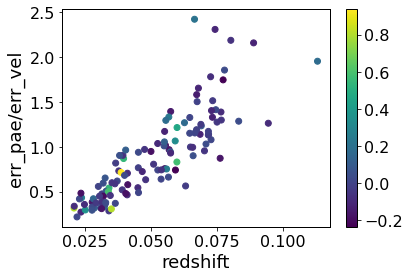

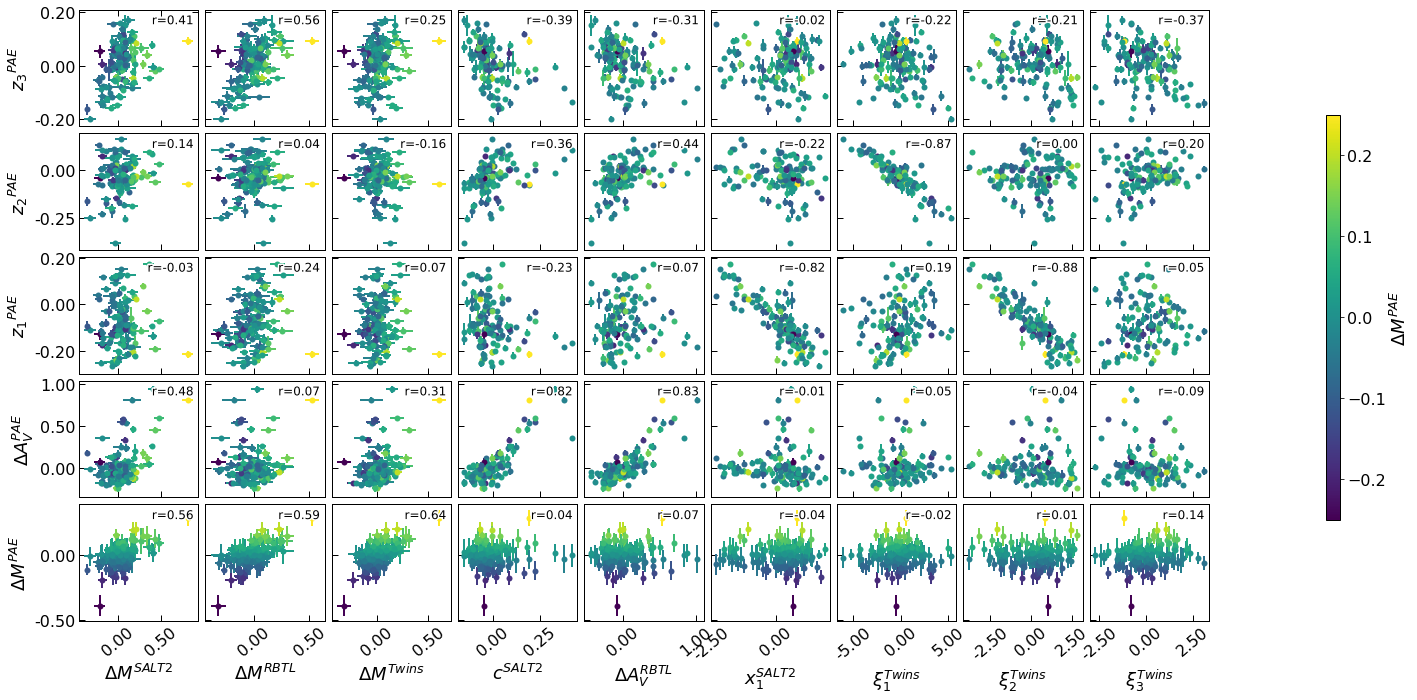

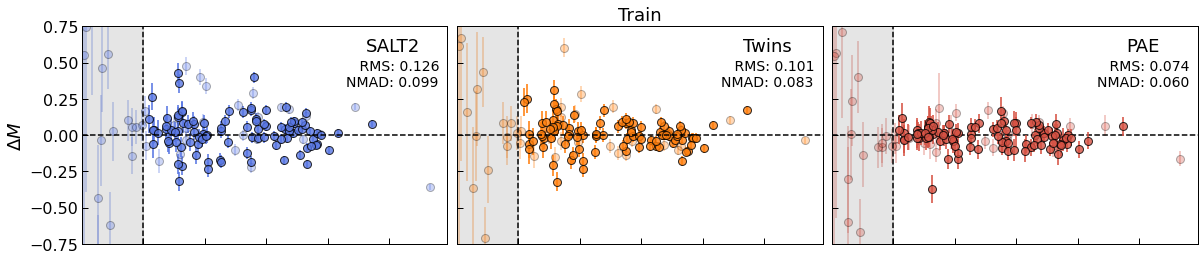

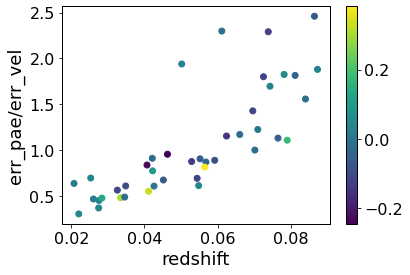

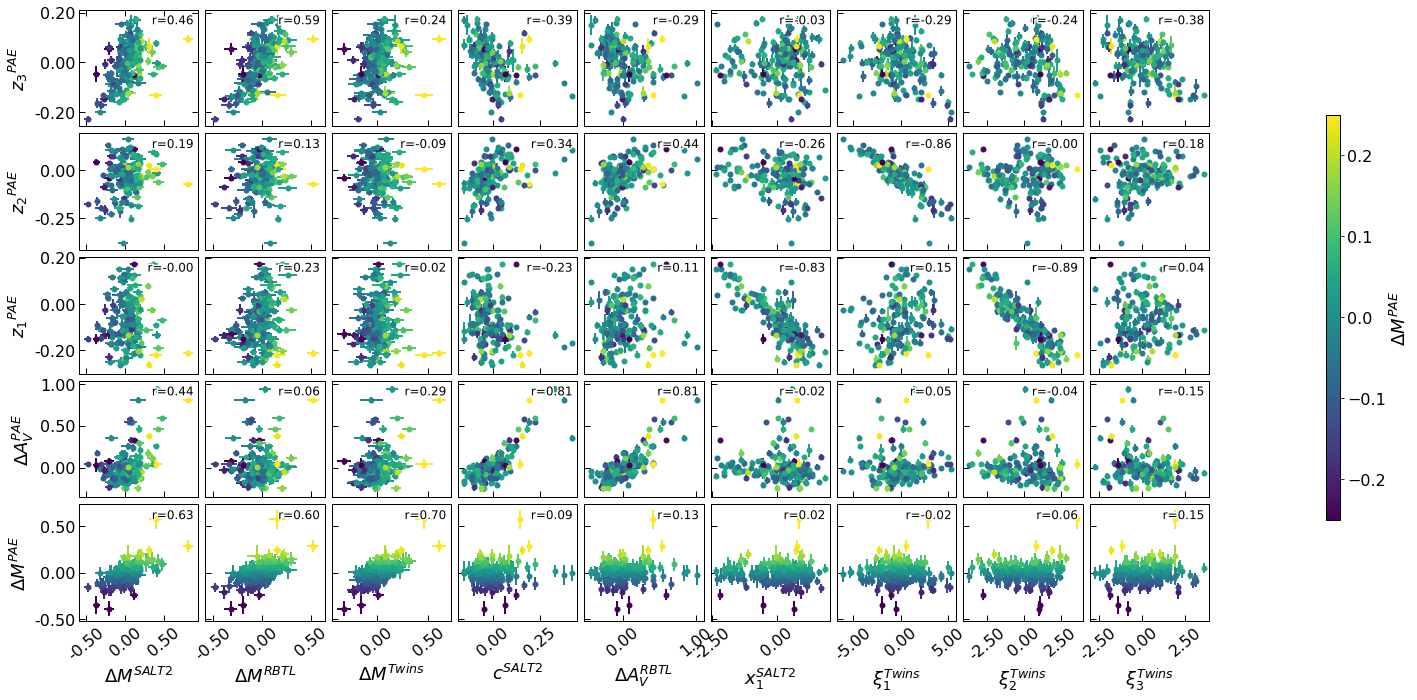

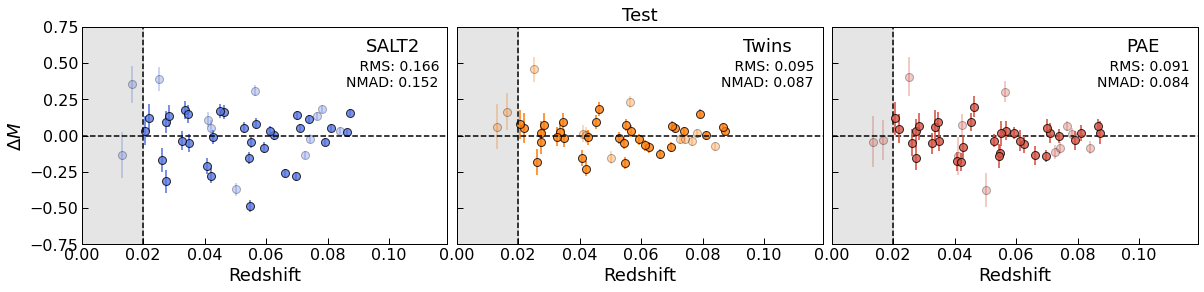

In [11]:
import pandas as pd

df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 3
kfold = 0

maxlightcut_str = ''


file_string = "layers256-128-32_3stage_train_decorrelate_all_seed0"

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

file_string = "layers256-128-32_3stage_train_decorrelate_all"

# savefig = True
savefig = False

# show_plot_grid = True
show_plot_grid = False

show_plot_grid_one_vs_other = True
# show_plot_grid_one_vs_other = False

# standardize = True
standardize = False

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 256))

c_pae = colors[int(0.9*len(colors))]
color_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.7*len(colors))]

ms = 8
yminmax = 0.75

alpha_out = 0.3

alpha0 = 0.6
alpha1 = 0.8

fontsize = 12
fontsize_meas = 14
fontsize_label = 18

ypos_meas = 0.85
ypos_label = 0.95

xpos_meas = 0.85
xpos_label = 0.85

frameon = True
if latent_dim==2: xyminmax = [[-0.4, 0.4], [0, 1], [-1.5, 1.5], [-0.5, 3], [-0.4, 0.4]]
if latent_dim==3: xyminmax = [[-0.4, 0.4], [-1.5, 0.5], [0, 0.3], [-1.5, 1.5], [-0.5, 0.75], [-0.4, 0.4]]

tstrs = ['train', 'test']
# tstrs = ['test']

# seeds_use = np.arange(8)
seeds_use = np.array([0, 1, 2, 3, 4, 5, 6, 7])#, 8, 9])

grid_xy = 2.25 #1.75
spacing = 0.06

for ti, tstr in enumerate(tstrs):
    
    if tstr=='train':
        data = train_data

        m = '*'
#         dm = np.full(train_data['maximum_likelihood'].shape[0], True, dtype=bool)
#         dm = train_data['maximum_likelihood'] > test_data['maximum_likelihood']

    if tstr=='test':
        m = '*'
        data = test_data

    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    xi1_twins = np.zeros(data['redshift'].shape[0])
    xi2_twins = np.zeros(data['redshift'].shape[0])
    xi3_twins = np.zeros(data['redshift'].shape[0])

    
    c_salt = data['c']
    x1_salt = data['x1']

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
        xi1_twins[ind_snf] = dfi['xi_1']
        xi2_twins[ind_snf] = dfi['xi_2']
        xi3_twins[ind_snf] = dfi['xi_3']

    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift) & \
                    (np.sum(data['mask'], axis=(1,2)) > 0)

    
    # Dl = c*z/H0
    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err to get new redshift      

    dl = z #(1+z)*z
    dl1 = z1 #(1+z1)*z1 # don't need leading constant c/H0
    
    # mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05
    mag_err_vel = abs(-5*np.log10(dl/dl1)) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]

    mask_grid = in_twins
    # mask_grid = mask_twins
    mask_grid = dm_redshift & mask_grid


    labels_pae = [
        # '$\Delta t$',
        '$\Delta M^{PAE}$',
        '$\Delta A_V^{PAE}$',
    ] + latent
    labels_twins = [
        r'$\xi_3^{Twins}$',
        r'$\xi_2^{Twins}$',
        r'$\xi_1^{Twins}$',
        r'$\Delta A_V^{RBTL}$',
        r'$\Delta m^{Twins}$',
        r'$\Delta m^{RBTL}$',
    ]
    labels_salt = ['$x_1^{SALT2}$',
                   '$c^{SALT2}$',
                   '$\Delta m^{SALT2}$',
                  ]

#     c_err = np.exp(data['z_latent_mcmc'][mask_twins][:, -1] + data['z_latent_mcmc_err'][mask_twins][:, -1]) - np.exp(data['z_latent_mcmc'][mask_twins][:, -1])
    arr_pae = data['z_latent_mcmc'][mask_grid, 1:]
    arr_pae_err = data['z_latent_mcmc_err'][mask_grid, 1:]
    
#     arr_pae[:, 0] *= 50
#     arr_pae_err[:, 0] *= 50
    
    arr_pae_err[:, 0] = np.sqrt(arr_pae_err[:,1]**2 + mag_err_vel[mask_grid]**2)

    # labels_pae = list(np.roll(labels_pae, -1))
    # arr_pae = np.roll(arr_pae, -1, axis=1)
    # arr_pae_err = np.roll(arr_pae_err, -1, axis=1)

    plt.figure()
    plt.scatter(data['redshift'][mask_grid], arr_pae_err[:,1]/mag_err_vel[mask_grid], c=arr_pae[:,1])
    plt.xlabel('redshift')
    plt.ylabel('err_pae/err_vel')
    plt.colorbar()
    
    arr_twins = np.c_[
        xi3_twins[mask_grid],
        xi2_twins[mask_grid],
        xi1_twins[mask_grid],
        av_rbtl[mask_grid],
        dm_resid_twins[mask_grid],
        dm_rbtl[mask_grid]]
    arr_twins_err = np.c_[
        xi1_twins[mask_grid]*0.,
        xi1_twins[mask_grid]*0.,
        xi1_twins[mask_grid]*0.,
        av_twins_err[mask_grid],
        dm_twins_err[mask_grid],
        dm_twins_err[mask_grid],
    ]
    
    arr_salt = np.c_[x1_salt[mask_grid], c_salt[mask_grid], dm_resid_salt[mask_grid]+mag_err_vel[mask_grid]]
    arr_salt_err = arr_salt*0.
    
    # arr_others = np.c_[arr_twins, arr_salt]
    # arr_others_err = np.c_[arr_twins_err, arr_salt_err]
    # labels_others = labels_twins + labels_salt
    labels_others = [
        r'$\xi_3^{Twins}$',
        r'$\xi_2^{Twins}$',
        r'$\xi_1^{Twins}$',
        '$x_1^{SALT2}$',
        '$\Delta A_V^{RBTL}$',
        '$c^{SALT2}$',
        '$\Delta M^{Twins}$',
        '$\Delta M^{RBTL}$',
        '$\Delta M^{SALT2}$',

        ]
    arr_others = np.c_[
        xi3_twins[mask_grid],
        xi2_twins[mask_grid],
        xi1_twins[mask_grid],
        x1_salt[mask_grid],
        av_rbtl[mask_grid],
        c_salt[mask_grid],
        dm_resid_twins[mask_grid],
        dm_rbtl[mask_grid],
        dm_resid_salt[mask_grid],
    ]
    arr_others_err = np.c_[
        xi3_twins[mask_grid]*0,
        xi2_twins[mask_grid]*0,
        xi1_twins[mask_grid]*0,
        x1_salt[mask_grid]*0,
        av_twins_err[mask_grid],
        c_salt[mask_grid]*0,
        dm_twins_err[mask_grid],
        dm_twins_err[mask_grid],
        dm_resid_salt[mask_grid]*0.+mag_err_vel[mask_grid],
    ]

    if tstr=='train':
        arr_pae_all = arr_pae.copy()
        arr_pae_err_all = arr_pae_err.copy()
        arr_others_all = arr_others.copy()
        arr_others_err_all = arr_others_err.copy()   
        # color_all = data['redshift'][mask_grid].copy()
        color_all = arr_pae[:, 0]
        
    if tstr=='test':
        arr_pae_all = np.concatenate([arr_pae_all, arr_pae], axis=0)
        arr_pae_err_all = np.concatenate([arr_pae_err_all, arr_pae_err])
        arr_others_all = np.concatenate([arr_others_all, arr_others], axis=0)
        arr_others_err_all = np.concatenate([arr_others_err_all, arr_others_err], axis=0)  
        color_all = np.concatenate([color_all, arr_pae[:, 0]])
        
    arr = np.c_[arr_pae, arr_twins, arr_salt]
    err = np.c_[arr_pae_err, arr_twins_err, arr_salt_err]
    labels = labels_pae + labels_twins + labels_salt
#     err = np.c_[data['amplitude_mcmc_err'][in_twins], data['z_latent_mcmc_err'][in_twins][:, 1:-1], c_err, data['dtime_mcmc_err'][in_twins]*50, av_twins_err[in_twins], dm_twins_err[in_twins]]

    if show_plot_grid:
        plot_grid(arr, labels=labels, color_arr=data['redshift'][mask_grid], errs=err, #xyminmax=xyminmax,
                  color_label='Redshift', cmap=plt.cm.viridis, figsize=(12,12), s=6,
                  savefig=savefig, filename=figdir+'AE_and_RBTL_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))

    if show_plot_grid_one_vs_other:
#         plot_grid_one_vs_other(arr_pae, arr_salt, labels1=labels_pae, labels2=labels_salt,
#                                errs1=arr_pae_err, errs2=arr_salt_err,
#                                color_arr=data['redshift'][mask_grid], spacing=spacing, #xyminmax=xyminmax,
#                   color_label='Redshift', cmap=plt.cm.viridis, figsize=(grid_xy*arr_pae.shape[1], grid_xy*arr_salt.shape[1]), s=6, markeredgecolor='none',
#                   savefig=savefig, filename=figdir+'PAE_vs_salt_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
        
#         plot_grid_one_vs_other(arr_pae, arr_twins, labels1=labels_pae, labels2=labels_twins,
#                                errs1=arr_pae_err, errs2=arr_twins_err,
#                                color_arr=data['redshift'][mask_grid], spacing=spacing, #xyminmax=xyminmax,
#                   color_label='Redshift', cmap=plt.cm.viridis, figsize=(grid_xy*arr_pae.shape[1], grid_xy*arr_twins.shape[1]), s=6, markeredgecolor='none',
#                   savefig=savefig, filename=figdir+'PAE_vs_twins_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
        
        
#         plot_grid_one_vs_other(arr_pae, arr_others, labels1=labels_pae, labels2=labels_others,
#                                errs1=arr_pae_err, errs2=arr_others_err,
#                                color_arr=data['redshift'][mask_grid], spacing=spacing, #xyminmax=xyminmax,
#                   color_label='Redshift', cmap=plt.cm.viridis, figsize=(grid_xy*arr_pae.shape[1], grid_xy*arr_others.shape[1]), s=6, markeredgecolor='none',
#                   savefig=savefig, filename=figdir+'PAE_vs_others_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
 
        print(arr_others.shape)
        plot_grid_one_vs_other(arr_others_all[:, ::-1], arr_pae_all[:, ::-1], labels1=labels_others[::-1], labels2=labels_pae[::-1],
                               errs1=arr_others_err_all[:, ::-1], errs2=arr_pae_err_all[:, ::-1],
                               color_arr=color_all, spacing=spacing, color_symmetric=True, #xyminmax=xyminmax,
                  color_label='$\Delta M^{PAE}$', cmap=cmap_scatter, figsize=(grid_xy*arr_others.shape[1], grid_xy*arr_pae.shape[1]), s=6, markeredgecolor='none',
                  savefig=savefig, filename=figdir+'PAE_vs_others_{:02d}latent_params_{:s}.pdf'.format(latent_dim, tstr))
        
    if standardize: 
        z_in = data['z_latent_mcmc'][:, start_dim:end_dim]
        # z_in[:, -1] = np.exp(z_in[:, -1])
        if standardize_time:
            z_in = np.c_[z_in, data['dtime_mcmc']]

        if 'NN' in fit_model:
            A_pred = Amodel.predict(z_in).flatten()
        if fit_model=='OLS':
            A_pred = pfit[0] + z_in @ pfit[1:]

        data['amplitude_mcmc'] -= A_pred
    


#     wrms_twins =  np.sqrt(np.sum( (dm_twins[in_twins][dm_redshift] - dm_twins[in_twins][dm_redshift].mean())**2 / dm_twins_err[in_twins][dm_redshift]**2) / np.sum(1./dm_twins_err[in_twins][dm_redshift]**2))
#     wrms_hmc =  np.sqrt(np.sum( (data['amplitude_mcmc'][in_twins][dm_redshift]- data['amplitude_mcmc'][in_twins][dm_redshift].mean())**2 / data['amplitude_mcmc_err'][in_twins][dm_redshift]**2) / np.sum(1./data['amplitude_mcmc_err'][in_twins][dm_redshift]**2))
#     mask_performance = in_twins

    mask_performance = mask_twins
    
    dm_redshift = dm_redshift[mask_performance]

    wrms_resid_salt =  np.std(dm_resid_salt[mask_twins]) 

    wrms_rbtl =  np.std(dm_rbtl[mask_twins]) 
    wrms_resid_twins =  np.std(dm_resid_twins[mask_twins]) 

    wrms_hmc =  np.std(data['amplitude_mcmc'][mask_twins]) 

    k_nmad = 1.4826
    mad_rbtl   = k_nmad * np.median( np.abs(dm_rbtl[mask_performance][dm_redshift] - np.median(dm_rbtl[mask_performance][dm_redshift]) ))
    mad_hmc    = k_nmad * np.median( np.abs(data['amplitude_mcmc'][mask_performance][dm_redshift] - np.median(data['amplitude_mcmc'][mask_performance][dm_redshift]) ))

    mad_resid_salt  = k_nmad * np.median( np.abs(dm_resid_salt[mask_performance][dm_redshift] - np.median(dm_resid_salt[mask_performance][dm_redshift]) ))
    mad_resid_twins = k_nmad * np.median( np.abs(dm_resid_twins[mask_performance][dm_redshift] - np.median(dm_resid_twins[mask_performance][dm_redshift]) ))

    lab_rbtl = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_rbtl, mad_rbtl)    
    lab_salt = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_resid_salt, mad_resid_salt)    
    lab_twins = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_resid_twins, mad_resid_twins)
    lab_hmc = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_hmc, mad_hmc)



    fig = plt.figure(figsize=(20,4))

    nx = 3
    # SALT
    ax = fig.add_subplot(1, nx, 1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_resid_salt[in_twins & ~mask_twins], yerr=mag_err_vel[in_twins & ~mask_twins],
                ms=ms, marker='o', color=color_salt, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)

    ax.errorbar(data['redshift'][mask_twins], dm_resid_salt[mask_twins], yerr=mag_err_vel[mask_twins],
                ms=ms, marker='o', label=lab_salt, color=color_salt, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha1)

    ax.text(xpos_meas, ypos_meas, lab_salt,
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_meas)
    ax.text(xpos_label, ypos_label, 'SALT2',
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_label)    
    
    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_ylabel('$\Delta M$')
    if tstr=='train':
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Redshift')

    # ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    # ax.set_title('SALT2', fontsize=18)

    
    ax = fig.add_subplot(1, nx, 2)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    # ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_rbtl[in_twins & ~mask_twins], yerr=dm_twins_err[in_twins & ~mask_twins],
    #             ms=ms, marker='o', color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    # ax.errorbar(data['redshift'][mask_twins], dm_rbtl[mask_twins], yerr=dm_twins_err[mask_twins],
    #             ms=ms, marker='o', label=lab_rbtl, color=c_bg, markeredgecolor='k', ls='none', lw=2, zorder=0, alpha=alpha0)

    ax.errorbar(data['redshift'][in_twins & ~mask_twins], dm_resid_twins[in_twins & ~mask_twins], yerr=dm_twins_err[in_twins & ~mask_twins],
                ms=ms, marker='o', color=c_twins, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data['redshift'][mask_twins], dm_resid_twins[mask_twins], yerr=dm_twins_err[mask_twins],
                ms=ms, marker='o', label=lab_twins, color=c_twins, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha1)

    ax.text(xpos_meas, ypos_meas, lab_twins,
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_meas)
    ax.text(xpos_label, ypos_label, 'Twins',
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_label)    
    

    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_yticklabels([])
    if tstr=='train':
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Redshift')

    # ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)
    ax.axhline(0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    ax.set_title(tstr.capitalize(), fontsize=18)
    

    for iseed, seed in enumerate(seeds_use):
        data_filei = f'../outputs/{tstr}_data_kfold{kfold}_posterior_{latent_dim:02d}Dlatent_{file_string}_seed{seed}{maxlightcut_str}.npy'
        datai = load_data(data_filei)

        if iseed == 0:
            A = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))
            A_err = np.zeros(( seeds_use.shape[0], datai['amplitude_mcmc'].shape[0] ))

        A[iseed] = datai['amplitude_mcmc']
        A_err[iseed] = np.sqrt(datai['amplitude_mcmc_err']**2)# + mag_err_vel**2)


    # ND
    for iplt in range(A.shape[0]):
        wrms_hmc =  np.std(A[iplt][mask_twins]) 
        lab_hmc = '$Model{:d}: \sigma={:.3f}, NMAD={:.3f}$'.format(iplt,  wrms_hmc, mad_hmc)

        k_nmad = 1.4826
        mad_hmc    = k_nmad * np.median( np.abs(A[iplt][mask_twins] - np.median(A[iplt][mask_twins]) ))

        # ax.errorbar(data['redshift'][in_twins & ~mask_twins], A[iplt][in_twins & ~mask_twins], yerr=A_err[iplt][in_twins & ~mask_twins],
        #             ms=ms, marker='o', color='C{:d}'.format(iplt%10), markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
        # ax.errorbar(data['redshift'][mask_twins], A[iplt][mask_twins], yerr=A_err[iplt][mask_twins],
        #             ms=ms, marker='o', color='C{:d}'.format(iplt%10), markeredgecolor='k', label=lab_hmc, ls='none', lw=2, zorder=4, alpha=alpha1) #

        
        
#     # http://seismo.berkeley.edu/~kirchner/Toolkits/Toolkit_12.pdf
    weight = 1./A_err**2
    n_eff = np.sum(weight*A, axis=0)**2/np.sum(weight**2, axis=0)

    # A_mean = A.mean(0)
    weighted_mean = np.sum(weight*A, axis=0)/np.sum(weight, axis=0)

    weighted_deviation  = np.sqrt(A.shape[0]/(A.shape[0] - 1) *  
                            ( np.sum(weight*A**2, axis=0)/np.sum(weight, axis=0) - weighted_mean**2))

    weighted_err = weighted_deviation #/np.sqrt(A.shape[0])
    weighted_err = np.sqrt(weighted_err**2 + mag_err_vel**2)

    # save final parameters to file
    np.savez('../data/final_magnitude_fits_{:s}{:s}.npz'.format(tstr, maxlightcut_str),
             dm=weighted_mean,
             dm_sig=weighted_err,
             dm_vel=mag_err_vel,

             dm_resid_salt=dm_resid_salt,
             dm_resid_salt_err=mag_err_vel,
             
             dm_rbtl=dm_rbtl,
             dm_rbtl_err=mag_err_vel,

             dm_resid_twins=dm_resid_twins,
             dm_resid_twins_err=dm_twins_err,
             
            in_twins=in_twins,
            mask_twins=mask_twins)
    
    wrms_hmc =  np.std(weighted_mean[mask_twins], axis=0)

    k_nmad = 1.4826
    mad_hmc = k_nmad * np.median( np.abs(weighted_mean[mask_twins] - np.median(weighted_mean[mask_twins]) ))

    lab_hmc = '   RMS: {:.3f}\nNMAD: {:.3f}'.format(wrms_hmc, mad_hmc)

    ax = fig.add_subplot(1, nx, 3)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')
   

    # ND
    # weighted_mean = A[0]
    # weighted_err = weighted_mean*0
    ax.errorbar(data['redshift'][in_twins & ~mask_twins], weighted_mean[in_twins & ~mask_twins], yerr=weighted_err[in_twins & ~mask_twins],
                ms=ms, marker='o', color=c_pae, markeredgecolor='k', ls='none', lw=2, zorder=1, alpha=alpha_out)
    ax.errorbar(data['redshift'][mask_twins], weighted_mean[mask_twins], yerr=weighted_err[mask_twins],
                ms=ms, marker='o', markeredgecolor='k', label=lab_hmc, color=c_pae, ls='none', lw=2, zorder=4, alpha=alpha1)
    
    ax.text(xpos_meas, ypos_meas, lab_hmc,
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_meas)
    ax.text(xpos_label, ypos_label, 'PAE',
            horizontalalignment='center', verticalalignment='top',
            transform=ax.transAxes, fontsize=fontsize_label)

    ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    if tstr=='train':
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Redshift')

    # ax.legend(frameon=True, loc='upper right', fontsize=fontsize, handletextpad=0.05)#, title=r'$\sigma, NMAD$')
    ax.axhline(0.0, color='k', ls='--')
    ax.axvline(min_train_redshift, color='k', ls='--')

    ax.set_xlim(0,0.119)
    ax.set_ylim(-yminmax,yminmax)
    ax.set_yticklabels([])

    plt.subplots_adjust(wspace=0.025, hspace=0.025)

    if savefig:
        plt.savefig(figdir+'deltamag_vs_others_{:02d}latent_{:s}.pdf'.format(latent_dim, tstr), bbox_inches='tight')
          

(164, 5)
Train mean : 0.033647, var : 0.174732


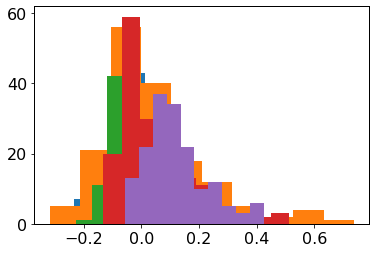

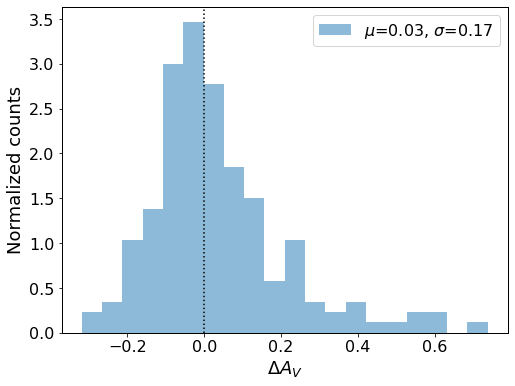

In [98]:
print(arr_pae_all[:, ::-1].shape)
for i in range(5):
    plt.hist(arr_pae_all[:, i])
    
    
import numpy as np
import sklearn
import sklearn.mixture
from scipy.stats import norm
import matplotlib.pyplot as plt

# np.save('dt_train', data_fit)


gmm = sklearn.mixture.GaussianMixture()

r_train = gmm.fit(arr_pae_all[:, 1][:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
gmm_mean_train =  r_train.means_[0, 0]
gmm_std_train = np.sqrt(r_train.covariances_[0, 0])
print("Train mean : %f, var : %f" % (gmm_mean_train, gmm_std_train))


plt.figure(figsize=(8,6))

plt.hist(arr_pae_all[:, 1], alpha=0.5, bins=20, color='C0', density=True, label='$\mu$=%.2f, $\sigma$=%.2f'%(gmm_mean_train, gmm_std_train))

xx = np.linspace(arr_pae_all[:, 1], arr_pae_all[:, 1], 100)
plt.plot(xx, norm.pdf(xx, gmm_mean_train, gmm_std_train), color='C0')

plt.axvline(0, color='k', ls=':')

plt.xlabel('$\Delta A_V$')
plt.ylabel('Normalized counts')

plt.legend(loc='upper right')

# plt.figure()
# plt.hist(arr_pae_all[:, 1])

# Perform bootstrap error sampling

In [78]:
#     np.savez(
#              deltam=weighted_mean,
#              deltam_sig=weighted_err,
#             in_twins=in_twins,
#             mask_twins=mask_twins)
def calculate_nmad(thetas):
    k_nmad = 1.4826
    nmad = k_nmad * np.median( np.abs(thetas - np.median(thetas)) )
    return nmad

def bootstrap_errors(thetas, nresample=10):
    # takes in list of measurements and performs boostrap sampling
    
    sample_rms = np.zeros(nresample)
    sample_nmad = np.zeros(nresample)

    for isamp in range(nresample):
        samples = np.random.choice(thetas, thetas.shape[0], replace=True)
        
        sample_rms[isamp] = np.std(samples)
        sample_nmad[isamp] = calculate_nmad(samples)
    
    bootstrap_rms  = np.mean(sample_rms)
    bootstrap_nmad = np.mean(sample_nmad)
    
    bootstrap_rms_std  = np.sqrt(1./(nresample-1) * np.sum( (bootstrap_rms - sample_rms)**2))
    bootstrap_nmad_std = np.sqrt(1./(nresample-1) * np.sum( (bootstrap_nmad - sample_nmad)**2))

    return bootstrap_rms_std, bootstrap_nmad_std

maxlightcut_str = ''
# maxlightcut_str = '_maxlightcut'

# ['dm', 'dm_sig', 'dm_resid_salt', 'dm_resid_salt_err', 'dm_rbtl', 'dm_rbtl_err', 'dm_resid_twins', 'dm_resid_twins_err', 'in_twins', 'mask_twins']
nbootstrap_sample = 10000

# dm_strs = ['dm_resid_salt', 'dm_rbtl', 'dm_resid_twins', 'dm']#, 'dm_vel']
dm_strs = ['dm']#, 'dm_vel']

dm_strs_to_display = {'dm': 'PAE',
                      'dm_resid_salt': 'SALT2',
                      'dm_resid_twins': 'Twins',
                       'dm_rbtl': 'RBTL',
                     'dm_vel': 'Vel'}

tstrs = ['train', 'test']
remove_vel = True
table = {}
for tstr in tstrs:
    tablei = {}

    for dm_str in dm_strs:
        data = np.load('../data/final_magnitude_fits_{:s}{:s}.npz'.format(tstr, maxlightcut_str))
        rms_vel = np.sqrt(np.sum(data['dm_vel'][data['mask_twins']]**2)/data['dm_vel'][data['mask_twins']].shape[0])
        print(rms_vel)

        print(tstr, data['in_twins'].sum(), data['mask_twins'].sum())
        measurements = data[dm_str][data['mask_twins']]

        rms =  np.std(measurements, axis=0)
        nmad = calculate_nmad(measurements)

        rms_std, nmad_std = bootstrap_errors(measurements, nbootstrap_sample)

        d = {}
        d['NMAD'] = '{:.3f} pm {:.3f}'.format(nmad, nmad_std)
        d['RMS'] = '{:.3f} pm {:.3f}'.format(rms, rms_std)
        d['RMS_noVel'] = '{:.3f} pm {:.3f}'.format(np.sqrt(rms**2-rms_vel**2), rms_std)

#         if remove_vel:
#             dm = measurements > 0
#             measurements_i = measurements[dm].copy()
#             measurements_i -= data['dm_vel'][data['mask_twins']][dm]
#             measurements_i[measurements_i < 0] = 0.
#             measurements[dm] = measurements_i
            
#             dm = measurements < 0
#             measurements_i = measurements[dm].copy()
#             measurements_i += data['dm_vel'][data['mask_twins']][dm]
#             measurements_i[measurements_i > 0] = 0.
#             measurements[dm] = measurements_i    
            
#         rms =  np.std(measurements, axis=0)
#         nmad = calculate_nmad(measurements)

#         rms_std, nmad_std = bootstrap_errors(measurements, nbootstrap_sample)
     
#         d['RMS_unexplained'] = '{:.3f} pm {:.3f}'.format(rms, rms_std)

        # d['rms_err'] = rms_std
        # d['nmad'] = nmad
        # d['nmad_err'] = nmad_std


        tablei[dm_strs_to_display[dm_str]] = d

        print(r'{:s}: RMS = {:.3f} $\pm$ {:.3f}, NMAD {:.3f} $\pm$ {:.3f}'.format(tstr, 
                                                                                  rms,
                                                                                  rms_std,
                                                                                  nmad,
                                                                                  nmad_std))
    table[tstr] = tablei
    
print(table)

0.0524253606386224
train 137 96
train: RMS = 0.074 $\pm$ 0.010, NMAD 0.060 $\pm$ 0.010
0.05343261553738733
test 44 32
test: RMS = 0.091 $\pm$ 0.010, NMAD 0.084 $\pm$ 0.023
{'train': {'PAE': {'NMAD': '0.060 pm 0.010', 'RMS': '0.074 pm 0.010', 'RMS_noVel': '0.052 pm 0.010'}}, 'test': {'PAE': {'NMAD': '0.084 pm 0.023', 'RMS': '0.091 pm 0.010', 'RMS_noVel': '0.074 pm 0.010'}}}


## Does magnitude residual depend on SN p(z) or p(u) density?

[96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11]
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11]


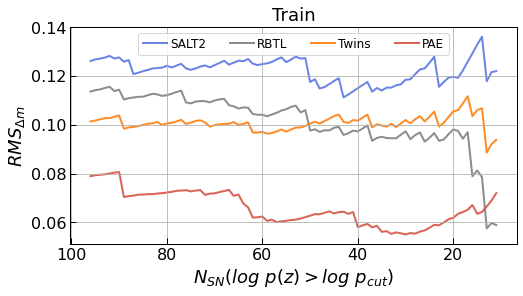

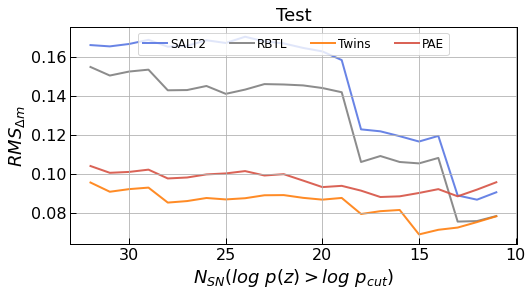

In [17]:
import pandas as pd

# savefig = True
savefig = False

# name,iau_name,salt_x1,salt_x1_err,salt_c,salt_c_err,rbtl_av,rbtl_av_err,rbtl_dm,rbtl_dm_err,xi_1,xi_2,xi_3,dm_residuals_twins,dm_residuals_salt,mask_twins,mask_salt
df_twins = pd.read_csv('../data/boone_data.dat', delimiter = ",")

latent_dim = 3
kfold = 0

# file_string = 'layers256-128-32_multistage_train_decorrelate_all'#_1e-3clip'
file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0' #_magnitude_nosig_twinscut_maxlight'   #_1e-3clip'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)


# standardize = True
standardize = False

cmap = plt.cm.coolwarm
colors = cmap(np.linspace(0, 1, 256))

c_pae = colors[int(0.9*len(colors))]
c_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.7*len(colors))]

ms = 8
yminmax = 0.75

alpha=0.9
alpha_out = 0.3

alpha0 = 0.6
alpha1 = 0.8

fontsize = 12
frameon = True
if latent_dim==2: xyminmax = [[-0.4, 0.4], [0, 1], [-1.5, 1.5], [-0.5, 3], [-0.4, 0.4]]
if latent_dim==3: xyminmax = [[-0.4, 0.4], [-1.5, 0.5], [0, 0.3], [-1.5, 1.5], [-0.5, 0.75], [-0.4, 0.4]]

tstrs = ['train', 'test']

grid_xy = 2

use_pz = True
ymin = -15

log_p_cuts = np.linspace(-5, -1, 100) #[-10., -5., -2.]

c_pae = colors[int(0.9*len(colors))]
c_salt = colors[int(0.1*len(colors))]
c_twins = 'C1'
c_bg = 'gray'
c_bg_2 = colors[int(0.7*len(colors))]

for ti, tstr in enumerate(tstrs):
    if tstr=='train':
        data = train_data
        m = '*'

    if tstr=='test':
        m = '*'
        data = test_data

        
    # get twins data for sn
    set_snf = set(list(data['names']))
    set_boone = set(list(df_twins['name']))

    intersection = list(set_snf & set_boone)
    in_twins = np.full(data['redshift'].shape[0], False)
    mask_twins = np.full(data['redshift'].shape[0], False)

    dm_rbtl = np.zeros(data['redshift'].shape[0])
    av_rbtl = np.zeros(data['redshift'].shape[0])

    dm_twins_err = np.zeros(data['redshift'].shape[0])
    av_twins_err = np.zeros(data['redshift'].shape[0])

    dm_resid_twins = np.zeros(data['redshift'].shape[0])
    dm_resid_salt = np.zeros(data['redshift'].shape[0])

    for i, name in enumerate(intersection):
        ind_snf = np.argwhere(data['names'] == name)[0]
        dfi = df_twins[df_twins['name'] == name]

        mask_twins[ind_snf] = dfi['mask_twins']
        in_twins[ind_snf]   = True

        dm_resid_twins[ind_snf] = dfi['dm_residuals_twins']
        dm_resid_salt[ind_snf] = dfi['dm_residuals_salt']

        dm_rbtl[ind_snf] = dfi['rbtl_dm']
        av_rbtl[ind_snf] = dfi['rbtl_av']

        dm_twins_err[ind_snf] = dfi['rbtl_dm_err']
        av_twins_err[ind_snf] = dfi['rbtl_av_err']
        
    min_train_redshift = 0.02
    max_train_redshift = 1.0

    dm_redshift = (data['redshift'] > min_train_redshift) & \
                  (data['redshift'] < max_train_redshift) & \
                    (np.sum(data['mask'], axis=(1,2)) > 0)

    mask_performance = mask_twins

    z = data['redshift']  
    z1 = (z*3e5+300.)/3e5 # add pec vel err      

    dl = (1+z)*z
    dl1 = (1+z1)*z1 # don't need leading constant c/H0
    
    mag_err_vel = -2.5*np.log10(((dl**2*(1+z))/(dl1**2*(1+z1)))) # factors to move to z=0.05

    latent = ['$z_{:d}$'.format(i+1) + '$^{PAE}$' for i in range(train_data['z_latent'].shape[1]-3)]


    if standardize: 
        z_in = data['z_latent_mcmc'][:, start_dim:end_dim]
        # z_in[:, -1] = np.exp(z_in[:, -1])
        if standardize_time:
            z_in = np.c_[z_in, data['dtime_mcmc']]

        if 'NN' in fit_model:
            A_pred = Amodel.predict(z_in).flatten()
        if fit_model=='OLS':
            A_pred = pfit[0] + z_in @ pfit[1:]

        data['amplitude_mcmc'] -= A_pred
   

    fig = plt.figure(figsize=(8, 4))

    lp_u = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(data['u_latent_mcmc']**2, axis=1)))

    if use_pz:
        lp_u -= data['logJ_u_latent_mcmc']

    lp_u -= lp_u.max()
    lp_u = np.nan_to_num(lp_u, nan=ymin)
    
    # lp_u = lp_u[mask_performance & dm_redshift]
    
    nx = 1
    # SALT
    ax = fig.add_subplot(1, 1, 1)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
    ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

    mask_performance = mask_twins

    inds_keep = np.arange(lp_u.shape[0])

    dm_resid_twins = dm_resid_twins[mask_performance]
    dm_resid_salt = dm_resid_salt[mask_performance]
    dm_rbtl = dm_rbtl[mask_performance]
    dm_pae = data['amplitude_mcmc'][mask_performance]

    lp_u = lp_u[mask_performance]
    inds_keep = inds_keep[mask_performance]

    inds_sort = np.argsort(lp_u)
    inds_lin = np.arange(lp_u.shape[0])

    wrms_resid_salt = []
    wrms_resid_twins = []
    wrms_rbtl = []
    wrms_hmc = []
    n_sn = []
    
    min_num = 10
    for ind_min in range(inds_sort.shape[0]-min_num):#, 0, -1):
        dm = inds_sort >= ind_min
        
        n_sn.append(dm.sum())

        wrms_resid_salt.append(np.std(dm_resid_salt[dm]) )

        wrms_rbtl.append(np.std(dm_rbtl[dm]) )
        wrms_resid_twins.append(np.std(dm_resid_twins[dm]) )
        
        wrms_hmc.append(np.std(dm_pae[dm]) )

    print(n_sn)
    ax.plot(n_sn, wrms_resid_salt,
                ms=ms, 
                color=c_salt, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='SALT2')

    ax.plot(n_sn, wrms_rbtl,
                ms=ms, 
                color=c_bg, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='RBTL')

    ax.plot(n_sn, wrms_resid_twins,
                ms=ms, 
                color=c_twins, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='Twins')

    ax.plot(n_sn, wrms_hmc,
                ms=ms, 
                color=c_pae, markeredgecolor='k',lw=2, zorder=1, alpha=alpha, label='PAE')

    ax.set_xlim(ax.get_xlim()[::-1])
    ax.grid()
    # ax.axvspan(0, min_train_redshift, alpha=0.2, color='gray')
    ax.set_xlabel('$N_{SN}(log\ p(z) > log\ p_{cut})$')
    ax.set_ylabel('$RMS_{\Delta m}$')
    
    ax.legend(frameon=True, loc='upper center', 
              fontsize=fontsize, handletextpad=0.25, ncol=4,
             bbox_to_anchor=(0.5, 1.00))#, title=r'$\sigma, NMAD$')
    # ax.axhline(0.0, color='k', ls='--')
    # ax.axvline(min_train_redshift, color='k', ls='--')

    # ax.set_xlim(0,0.119)
    # ax.set_ylim(-yminmax,yminmax)
    # ax.set_yticklabels([])

    ax.set_title(tstr.capitalize(), fontsize=18)

    if savefig:
        plt.savefig(figdir+'deltamag_vs_density_{:02d}latent_{:s}.pdf'.format(latent_dim, tstr), bbox_inches='tight')
          

# Anomaly Detection

In [15]:
latent_dim = 3

file_string = 'layers256-128-32_3stage_train_decorrelate_all_seed0'

train_data_file = '../outputs/train_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)
test_data_file  = '../outputs/test_data_kfold{:d}_posterior_{:02d}Dlatent_{:s}.npy'.format(kfold, latent_dim, file_string)

train_data = load_data(train_data_file)
test_data  = load_data(test_data_file)

params['min_train_redshift'] = 0.02
params['max_train_redshift'] = 1.00

params['max_light_cut'] = [-10, 40]
params['twins_cut'] = False


In [16]:
weird = ['SNF20070528-003', 
'SNF20070912-000', 
'SNF20080723-012', 
'SN2009ig',        
'SN2005di',        
'SNF20061009-008', 
'SNF20071001-005',
        ]
np.isin(test_data['names'], weird)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
# load in data for peculiar galaxies
peculiar_sn = np.genfromtxt('../data/peculiar_sn.txt', delimiter='\t', dtype=None, names=('name', 'peculiar_type'))
peculiar_sn_names = [peculiar_sn[i][0].split()[0].decode("utf-8") for i in range(peculiar_sn.shape[0])]
peculiar_sn_types = [peculiar_sn[i][0].split()[1].decode("utf-8") for i in range(peculiar_sn.shape[0])]

print(peculiar_sn_names)
print(peculiar_sn_types)

train_data['sn_type'] = ['normal']*len(train_data['names'])
test_data['sn_type'] = ['normal']*len(test_data['names'])

for n, t in zip(peculiar_sn_names, peculiar_sn_types):
    
    if n in train_data['names']:
        ind = np.argwhere(train_data['names']==n)[0][0]
        train_data['sn_type'][ind] = t
 
    if n in test_data['names']:
        ind = np.argwhere(test_data['names']==n)[0][0]
        test_data['sn_type'][ind] = t
    

['SNF20070528-003', 'SNF20070803-005', 'SNF20070825-001', 'SNF20070912-000', 'SNF20080522-000', 'SNF20080723-012', 'SNF20080805-007', 'LSQ12cyz', 'LSQ12fhe', 'PTF11bju', 'PTF11mkx', 'LSQ12cfx', 'PTF10ops', 'PTF11bkf', 'PTF11kjn', 'PTF11okh', 'PTF11pra', 'PTF12dwm', 'SN2005bl', 'SN2005dh', 'SN2005dm', 'SN2007ba', 'SN2009hs', 'SNNGC6430', 'SN2005cc', 'SNBOSS38', 'SN2012dn', 'SNNGC2691', 'SN2011hr', 'SN2006X']
['91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91T-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '91bg-like', '02cx-like', '09dc-like', '09dc-like', '91T-like', '91T-like', 'extreme']


<ipython-input-17-4a14c1e0332c>:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  peculiar_sn = np.genfromtxt('../data/peculiar_sn.txt', delimiter='\t', dtype=None, names=('name', 'peculiar_type'))


In [18]:
np.argwhere(train_data['names'] == "SNPGC51271")

array([[102]])

In [19]:
# change SN names from internal to external
sn_names = np.genfromtxt('../data/name_convention_sn.txt', delimiter='\t', dtype=None, names=('name_in', 'name_out'))
names_in = [sn_names[i][0].split()[0].decode("utf-8") for i in range(sn_names.shape[0])]
names_out = [sn_names[i][0].split()[1].decode("utf-8") for i in range(sn_names.shape[0])]

print(names_in, names_out)
train_names_in = train_data['names']
train_names_out = train_data['names']

test_names_in = test_data['names']
test_names_out = test_data['names']

for n_in, n_out in zip(names_in, names_out):
    
    if n_in in train_data['names']:
        print('name change train ', n_in, n_out)
        ind = np.argwhere(train_data['names']==n_in)[0][0]
        train_names_out[ind] = n_out
 
    if n_in in test_data['names']:
        print('name change test ', n_in, n_out)
        ind = np.argwhere(test_data['names']==n_in)[0][0]
        test_names_out[ind] = n_out
 
train_data['names'] = train_names_out
test_data['names'] = test_names_out

['Boles130718', 'CSS110918_01', 'CSS110918_02', 'PQOT0241-0338', 'PTF09dro', 'SDSS16392', 'SN2007pip', 'SN7876', 'SNBOSS38', 'SNhunt281', 'SNhunt46', 'SNhunt89', 'SNIC219', 'SNIC3573', 'SNISSP120630', 'SNNGC0927', 'SNNGC1401', 'SNNGC2370', 'SNNGC2691', 'SNNGC2891', 'SNNGC4076', 'SNNGC4424', 'SNNGC6343', 'SNNGC6430', 'SNNGC6619', 'SNNGC6801', 'SNNGC6956', 'SNNGC7364', 'SNNGC7589', 'SNPGC027923', 'SNPGC1354027', 'SNPGC51271', 'SNUGC11797', 'SNUGC12809', 'SNUGC2384', 'SNUGC2855', 'UT-06-2-015', 'WL2007ge'] ['SN2013ed', 'SN2011gf', 'SN2011ga', 'SN2007no', 'SN2009ih', 'SN2006ob', 'SN2007qe', 'SN2005ir', 'SN2012dn', 'AT2015bp', 'SN2011be', 'SN2011ho', 'SN2005dm', 'SN2013be', 'SN2012df', 'PSNJ02263653+120855', 'SN2011iv', 'PSNJ07250042+234703', 'SN2011hr', 'SN2013cg', 'SN2011bc', 'SN2012cg', 'SN2013bs', 'SN2012ea', 'SN2012dz', 'SN2011df', 'PSNJ20435314+123030', 'SN2011im', 'SN2011hv', 'SN2011ia', 'SN2011io', 'SN2013bt', 'SN2015N', 'SN2011iu', 'SN2006os', 'SN2014dg', 'SN2006cj', 'SN2007ge']
na

<ipython-input-19-2570f6ec21df>:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sn_names = np.genfromtxt('../data/name_convention_sn.txt', delimiter='\t', dtype=None, names=('name_in', 'name_out'))


In [20]:
#recheck SN types given SN name can have been updated 
for n, t in zip(peculiar_sn_names, peculiar_sn_types):
    
    if n in train_data['names']:
        ind = np.argwhere(train_data['names']==n)[0][0]
        train_data['sn_type'][ind] = t
 
    if n in test_data['names']:
        ind = np.argwhere(test_data['names']==n)[0][0]
        test_data['sn_type'][ind] = t
    

In [21]:
train_data['sn_type'] = np.array(train_data['sn_type'])
test_data['sn_type']  = np.array(test_data['sn_type'])

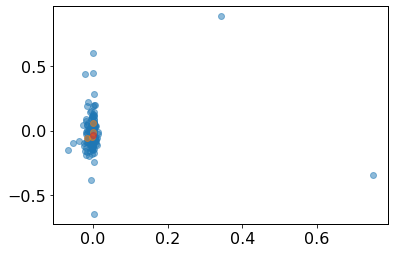

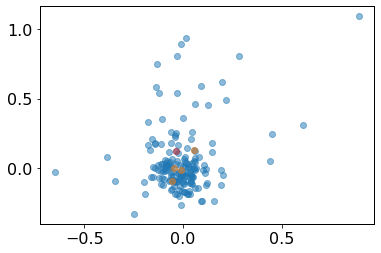

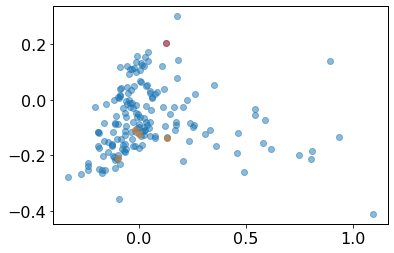

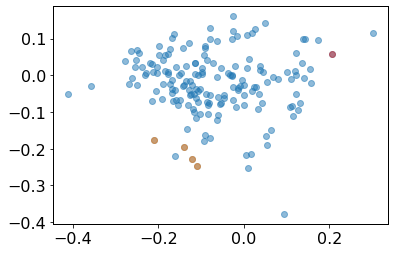

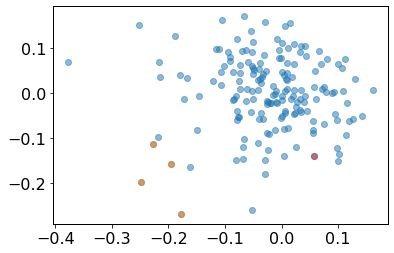

In [22]:
# plot sn belonging to types

data = train_data
# data = test_data
dm_T = data['sn_type'] == '91T-like'
dm_bg = data['sn_type'] == '91bg-like'

for j in range(data['z_latent_mcmc'].shape[1] - 1):
    plt.figure()
    plt.scatter(data['z_latent_mcmc'][:, j], data['z_latent_mcmc'][:, j+1], alpha=0.5)
    plt.scatter(data['z_latent_mcmc'][dm_T, j], data['z_latent_mcmc'][dm_T, j+1], alpha=0.5, c='C1')
    plt.scatter(data['z_latent_mcmc'][dm_bg, j], data['z_latent_mcmc'][dm_bg, j+1], alpha=0.5, c='C3')

    # plt.xlim(-20,20)
    # plt.ylim(-20,20)
    # plt.xlabel(labels[j])
    # plt.ylabel(labels[j+1])
 

-44.572605 -14.88161
SN2012cu
PSNJ07250042+23
SN2005bc
SN2006X
PTF12ena
SNF20071015-000
PTF12hwb
SNF20060609-002
PTF10ops
SN2011hr
SN2005hj
SNF20080918-000
SNF20061022-014
LSQ13avx
[ 88  17  51 135   1 170  45 151 113   8  73   4  19 129  67 159  53  16
 127  71 166  94  59 139 123 142  77 146  90 111  84 149  26  68  65   2
 112  34  85 162  29   3  86  83  40  63  98  72 152 133  50 147  60  35
 115 128  89 116 108 110 140 137  12 148  57 150  38  55  48  62 169  20
  37  69 156  49 164 103 165  42   0  15 122 102  78  81  46  52  91 136
 106 120  36 114 130 109  41 141   7  32  27  33 104 163 121 100 126  28
  25  39   5  43  13  96  24 161  22 134  21  61  93  74 158  44   9 119
 144 168 138  75  92  97  82  70  58 107  10 118  47 105 160  54 131  64
 154  87  30   6 155 125 157  66 167  14 124  31 132  99  23  18  95  80
  56  76 153 145  79 101  11 117 143]
[[88]]
[]


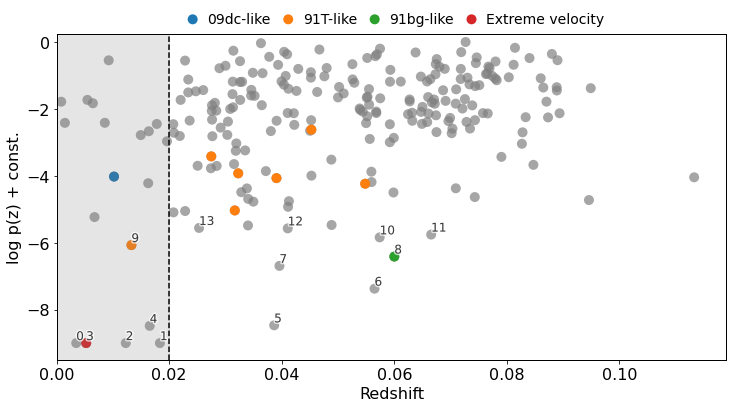

In [33]:
import matplotlib.patheffects as pe

savefig=True
# savefig=False

# use_pz = False
use_pz = True

num_annotate = 10 # number of low p samples to annotate
pcut_annotate = -5.5

fontsize = 12
text_rotation_angle = 0 #-40
text_lw = 2

dx = 0.0005
dy_max = 0.25
dy_min = 0.5

nplt_train = 3
nplt_test = 3
nplt_train_max = 4
nplt_test_max = 0

ms = 100

fontsize_label=16

alpha_train = 0.7
alpha_test = 0.7
alpha_pec = 1.0

ymin = -9 - dy_min
ymax = 0

peculiar_colors = ['C0', 'C1', 'C2', 'C3']
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
# 2D
print(train_data['logp_u_latent_mcmc'].min(), test_data['logp_u_latent_mcmc'].min())

p_u_train = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(train_data['u_latent_mcmc']**2, axis=1)))
p_u_test  = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(test_data['u_latent_mcmc']**2, axis=1)))

if use_pz:
    p_u_train -= train_data['logJ_u_latent_mcmc']
    p_u_test  -= test_data['logJ_u_latent_mcmc']

p_u_train = np.nan_to_num(p_u_train, nan=ymin)
p_u_test = np.nan_to_num(p_u_test, nan=ymin)

pmax = max(p_u_train.max(), p_u_test.max())

inds_train = np.argsort(p_u_train)#[::-1]
inds_test = np.argsort(p_u_test)#[::-1]

inds_train_max = np.argsort(p_u_train)[::-1]
inds_test_max = np.argsort(p_u_test)[::-1]

p_u_train -= pmax
p_u_test -= pmax

dm_test = p_u_test == False
dm_train = p_u_train == False

p_u_test[p_u_test < ymin+dy_min] = ymin+dy_min
p_u_train[p_u_train < ymin+dy_min] = ymin+dy_min

dm_train[p_u_train < ymin+dy_min] = True
dm_test[p_u_test < ymin+dy_min] = True

# z_train = train_data['redshift']
# z_test  = train_data['redshift']

ax.scatter(train_data['redshift'], p_u_train, edgecolor='none', color='gray', alpha=alpha_train, s=ms)
ax.scatter(test_data['redshift'], p_u_test, edgecolor='none', color='gray', alpha=alpha_test, s=ms)

peculiar_strings = sorted(np.unique( np.concatenate((train_data['sn_type'], test_data['sn_type']))))
ic = 0
for i, peculiar_string in enumerate(peculiar_strings):
    if peculiar_string not in ['normal']:
        dm_train = train_data['sn_type'] == peculiar_string
        dm_test = test_data['sn_type'] == peculiar_string

        if peculiar_string == 'extreme':
            peculiar_string = 'Extreme velocity'
            
        ax.scatter(train_data['redshift'][dm_train], p_u_train[dm_train], 
                   edgecolor='none', color=peculiar_colors[ic], alpha=alpha_pec, s=ms)
        
    
        ax.scatter(test_data['redshift'][dm_test], p_u_test[dm_test],
                   label=peculiar_string, edgecolor='none', color=peculiar_colors[ic], alpha=alpha_pec, s=ms)

#         for i, name in enumerate(train_data['names'][dm_train]):
#             ax.annotate(name, (dx+train_data['redshift'][dm_train][i], p_u_train[dm_train][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                              path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
#             # txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            
#         for i, name in enumerate(test_data['names'][dm_test]):
#             ax.annotate(name, (dx+test_data['redshift'][dm_test][i], p_u_test[dm_test][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])

                
        ic+=1
        
p_u = np.concatenate((p_u_train, p_u_test))
redshift = np.concatenate((train_data['redshift'], test_data['redshift']))
names = np.concatenate((train_data['names'], test_data['names']))


inds_sort = np.argsort(p_u)

p_u = p_u[inds_sort]
dm = p_u <= pcut_annotate

p_u = p_u[dm]
redshift = redshift[inds_sort][dm]
names = names[inds_sort][dm]

for i in range(p_u.shape[0]):
    ha = 'left'
    va = 'bottom'
    # if i==0:
        # ha = 'right'
    ax.text(redshift[i], p_u[i], f"{i}", #: {names[i]}", 
            color='k', alpha=alpha_train,
           path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()], ha=ha, va=va, rotation=text_rotation_angle, fontsize=12)
    print(names[i])

# peculiar_string = '91bg-like'
# dm_train = train_data['sn_type'] == peculiar_string
# dm_test = test_data['sn_type'] == peculiar_string

# ax.scatter(train_data['redshift'][dm_train], train_data['logp_u_latent_mcmc'][dm_train], 
#            label=peculiar_string, edgecolor='k', color=peculiar_colors[1], alpha=0.5)
# ax.scatter(test_data['redshift'][dm_test], test_data['logp_u_latent_mcmc'][dm_test],
#            edgecolor='k', color=peculiar_colors[1], alpha=0.9)

# dm_train = train_data['sn_type'] == '09dc-like'
# dm_test = test_data['sn_type'] == '09dc-like'

# dm_train = train_data['sn_type'] == '02cx-like'
# dm_test = test_data['sn_type'] == '02cx-like'

# ax.scatter(train_data['redshift'][dm_train], train_data['logp_u_latent_mcmc'][dm_train], label='Train', edgecolor='k', color='b', alpha=0.5)
# ax.scatter(test_data['redshift'][dm_test], test_data['logp_u_latent_mcmc'][dm_test], label='Test', edgecolor='k', color='b', alpha=0.9)


ax.axvspan(0, params['min_train_redshift'], alpha=0.2, color='gray')
ax.set_xlabel('Redshift', fontsize=fontsize_label)

ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.105), 
          fontsize=fontsize_label-2, handletextpad=0.05, ncol=4, columnspacing=0.25)
ax.axvline(params['min_train_redshift'], color='k', ls='--')

ax.set_xlim(0,0.119)
ax.set_ylim(ymin, ymax+dy_max)
#
# ax.set_ylim(-yminmax,yminmax)

if use_pz:
    ax.set_ylabel('log p(z) + const.', fontsize=fontsize_label)
else:
    ax.set_ylabel('log p(u) + const.', fontsize=fontsize_label)
    
plt.subplots_adjust(wspace=0.025, hspace=0.025)


print(inds_train)
inds_lin = np.arange(inds_train.shape[0]+inds_test.shape[0])

# for i, name in enumerate(train_data['names'][inds_train][:nplt_train]):
#     ax.annotate(name, (dx+train_data['redshift'][inds_train][i], p_u_train[inds_train][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
                
# for i, name in enumerate(test_data['names'][inds_test][:nplt_test]):
#     ax.annotate(name, (dx+test_data['redshift'][inds_test][i], p_u_test[inds_test][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
     
# for i, name in enumerate(train_data['names'][inds_train_max][:nplt_train_max]):
#     ax.annotate(name, (dx+train_data['redshift'][inds_train_max][i], p_u_train[inds_train_max][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
                
# for i, name in enumerate(test_data['names'][inds_test_max][:nplt_test_max]):
#     ax.annotate(name, (dx+test_data['redshift'][inds_test_max][i], p_u_test[inds_test_max][i]),
#                 fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
#                 path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])
     

inds_below = np.argwhere(dm_train == True)
print(inds_below)

inds_below = np.argwhere(dm_test == True)
print(inds_below)

# print(dm_train)
# print(dm_test)


if savefig:
    if use_pz:
        plt.savefig('../figures/log_pz_all.pdf', bbox_inches='tight')     
    else:
        plt.savefig('../figures/log_pu_all.pdf', bbox_inches='tight')     

                


# dm_redshift_train = (data_train['redshifts'] > train_data['min_train_redshift']) & \
#               (data_train['redshifts'] < train_data['max_train_redshift'])



(228, 4) (228, 4)


<ipython-input-36-3588321f9a18>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)
<ipython-input-36-3588321f9a18>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)
<ipython-input-36-3588321f9a18>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=-15)


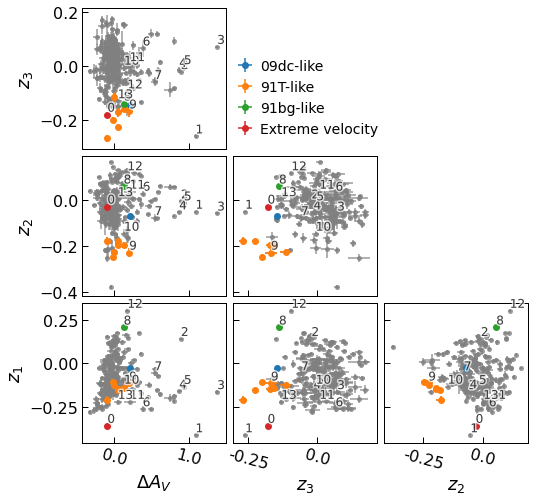

In [36]:
import matplotlib.gridspec as gridspec

# savefig = False
savefig = True

def plot_grid(data, labels=None, errs=None, names=None, sn_type=None, color_arr=None, color_label=None, xyminmax=None,
              figsize=(8,8), spacing=0.05, s=30, alpha=1.0, cmap=plt.cm.viridis, markeredgecolor='k',
              savefig=False, filename='plot_grid.pdf', rasterized=False, num_annotate=0):
    """plot variables against each other. Similar to seaborns pairplot, but more functionality"""
    nx = data.shape[1]-1
    ny = data.shape[1]-1

    if labels is None:
        labels = ['z_{:d}'.format(i) for i in range(data.shape[1])]
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(ncols=ny, nrows=nx, figure=fig)

    plt.subplots_adjust(wspace=spacing, hspace=spacing)
    peculiar_colors = ['C0', 'C1', 'C2', 'C3']

    if cmap is None:
        cmap = plt.cm.viridis
       
    for i in range(nx):
        for j in range(i, ny):
            
            ii = ny-j
            jj = (ny-i+1)%(ny+1)

            ax = fig.add_subplot(gs[j, i])
            if color_arr is not None:
                if i==0 and j==0:
                    xx = np.linspace(color_arr.min(), color_arr.max(), 256)
                    dummie_cax = ax.scatter(xx, xx, c=xx, cmap=cmap)
                    # Clear axis
                    ax.cla()

            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set_linewidth(1.)

            ax.tick_params('both', length=6, width=1., which='major', color='k', direction='in')                                         
            ax.tick_params('both', length=3, width=1., which='minor', color='k', direction='in')

            if i == 0:
                ax.set_ylabel(labels[ii])
            else:
                ax.set_yticklabels([])
            
            if j == ny-1:
                ax.set_xlabel(labels[jj])
            else:
                ax.set_xticklabels([])

            if color_arr is None:
                if errs is None:
                    ax.scatter(data[:, jj], data[:, ii], s=s, alpha=alpha, rasterized=rasterized)
                else:
                    ax.errorbar(data[:, jj], data[:, ii], xerr=errs[:, jj], yerr=errs[:, ii], marker='o', color='gray',
                                ms=s, alpha=alpha, markeredgecolor=markeredgecolor,
                                rasterized=rasterized, ls='none', zorder=-1)
                    
                    peculiar_strings = ['09dc-like', '91T-like', '91bg-like', 'extreme', 'normal']
                    ic = 0
                    for ipec, peculiar_string in enumerate(peculiar_strings):
                        if peculiar_string not in ['normal']:
                            dm = sn_type == peculiar_string

                            if peculiar_string == 'extreme':
                                peculiar_string = 'Extreme velocity'

                            ax.errorbar(data[dm, jj], data[dm, ii], xerr=errs[dm, jj], yerr=errs[dm, ii], marker='o', color=peculiar_colors[ic],
                                ms=s+2, markeredgecolor=markeredgecolor,
                                rasterized=rasterized, ls='none', alpha=alpha_pec, label=peculiar_string)
                    
                            # ax.scatter(data[dm, jj], data[dm, ii], 
                            #            edgecolor='k', color=peculiar_colors[ic], alpha=alpha_pec, s=ms)

                            # for iii, name in enumerate(names[dm]):
                            #     ax.annotate(name, (dx+data[dm, jj][iii], data[dm, ii][iii]),
                            #         fontsize=fontsize, ha='left', va='top', rotation=text_rotation_angle,
                            #                      path_effects=[pe.Stroke(linewidth=text_lw, foreground='w'), pe.Normal()])

                            ic += 1
            else:
                if errs is None:
                    c = ax.scatter(data[:, jj], data[:, ii], s=s, c=color_arr, edgecolors='k', lw=0.25, alpha=alpha, cmap=cmap, rasterized=rasterized)
                else:
                    carr = (color_arr-color_arr.min())/(color_arr.max()-color_arr.min())
                    for ierr in range(data[:, jj].shape[0]):
                        ax.errorbar(data[ierr, jj], data[ierr, ii], xerr=errs[ierr, jj], yerr=errs[ierr, ii], markeredgecolor=markeredgecolor,
                                    color=cmap(carr[ierr]), marker='o', ms=s, alpha=alpha, rasterized=rasterized, ls='none', 
                                     lw=2)

            for iann in range(num_annotate):
                ha = 'left'
                va = 'bottom'
                # if iann==0:
                #     ha = 'right'
                ax.text(data[iann, jj], data[iann, ii], f"{iann}", color='k', alpha=alpha_train,
                       path_effects=[pe.Stroke(linewidth=3, foreground='w'), pe.Normal()], ha=ha, va=va, fontsize=12)


            if xyminmax is not None:
                ax.set_ylim(xyminmax[ii])
                ax.set_xlim(xyminmax[jj])
                
            if j == ny-1:
                ax.set_xticklabels(ax.get_xticks(), rotation=-15)
            if i == nx//2 and j==ny//2:
                ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1.05), 
                          fontsize=fontsize_label-2, handletextpad=0.05, ncol=1, columnspacing=0.25)                
    if color_arr is not None:
        cax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
        fig.colorbar(dummie_cax, cax=cax, label=color_label)

    if savefig:
        plt.savefig(filename, bbox_inches='tight')
        
        

filename = '../figures/grid_PAE_{:d}Dlatent_peculiar_all.pdf'.format(latent_dim)

# latent = 'u_latent_mcmc'
latent = 'z_latent_mcmc'

data = {}
data['names'] = np.concatenate((train_data['names'], test_data['names']), axis=0)
data['sn_type'] = np.concatenate((train_data['sn_type'], test_data['sn_type']), axis=0)
data['z_latent_mcmc'] = np.concatenate((train_data[latent], test_data[latent]), axis=0)
data['z_latent_mcmc_err'] = np.concatenate((train_data[latent+'_err'], test_data[latent+'_err']), axis=0)

if latent == 'z_latent_mcmc':
    data['z_latent_mcmc'][:,0] *= 50 #days
    data['z_latent_mcmc_err'][:,0]  *= 50 #days

data['redshift'] = np.concatenate((train_data['redshift'], test_data['redshift']), axis=0)
data['times_orig'] = np.concatenate((train_data['times_orig'], test_data['times_orig']), axis=0)

p_u_train = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(train_data['u_latent_mcmc']**2, axis=1)))
p_u_test  = np.log(1./np.sqrt(2*np.pi) * np.exp(-1./2 * np.sum(test_data['u_latent_mcmc']**2, axis=1)))

if use_pz:
    p_u_train -= train_data['logJ_u_latent_mcmc']
    p_u_test  -= test_data['logJ_u_latent_mcmc']
    
pmax = max(p_u_train.max(), p_u_test.max())

p_u_train -= pmax
p_u_test -= pmax

p_u = np.concatenate((p_u_train, p_u_test))
inds_sort = np.argsort(p_u)
for k, v in data.items(): 
    if v.shape[0] == inds_sort.shape[0]:
        data[k] = v[inds_sort] # sort, so that first in array are ones to annotate

dm = p_u <= pcut_annotate
num_annotate = np.sum(dm)
    
# dm = get_train_mask(data, params)
dm = np.full(data['redshift'].shape[0], True, dtype=bool)

names = data['names'][dm]
sn_type = data['sn_type'][dm]

istart = 0
labels = ['$u_{:d}$'.format(i+1) for i in range(data['z_latent_mcmc'].shape[1])]
if latent == 'z_latent_mcmc':
    istart = 2
    labels = ['$\Delta A_V$'] + ['$z_{:d}$'.format(i+1) for i in range(latent_dim)]

arr_use = data['z_latent_mcmc'][dm, istart:]
err_use = data['z_latent_mcmc_err'][dm, istart:]


print(arr_use.shape, err_use.shape)
# labels = np.roll(labels, -1)
# arr_use = np.roll(arr_use, -1, axis=1)
# err_use = np.roll(err_use, -1, axis=1)

plot_grid(arr_use, errs=err_use, names=names, sn_type=sn_type, 
          labels=labels, savefig=savefig, filename=filename,
         figsize=(8, 8), s=5, alpha=0.8, markeredgecolor='none', num_annotate=num_annotate) 


# ax.scatter(train_data['redshift'], p_u_train, edgecolor='k', color='gray', alpha=alpha_train, s=ms)
# ax.scatter(test_data['redshift'], p_u_test, edgecolor='k', color='gray', alpha=alpha_test, s=ms)



In [120]:
arr_use.shape, names.shape
ind_use = 2
dm = arr_use[:, ind_use] > 0.3

ind_sort = np.argsort(arr_use[dm][:, ind_use])[::-1]
print(ind_sort)
arr_use[dm][ind_sort], names[dm][ind_sort], sn_type[dm][ind_sort]

'SN2012cu', 'LSQ12cyz', 'PTF11mkx', 'SN2006X', 'SNF20070803-005',
        'LSQ12fhe', 'SN2011hr', 'LSQ12gdj', 'PTF11bju', 'SNF20080522-000',
        'SNF20080720-001', 'PTF10ygu', 'PSNJ07250042+23', 'SN2007le',
        'SNF20060624-019', 'LSQ12gxj'

[ 1  8 12  6 10 14 13  3  7 11  2  5 15  0  9  4]


(array([[ 0.92259777,  0.16979432,  0.61394554,  0.16741659],
        [-0.13807665,  0.12768789,  0.59067297,  0.20680031],
        [-0.14589068,  0.12466559,  0.51285934,  0.23703186],
        [ 1.2661036 , -0.00702261,  0.47255805,  0.00557441],
        [-0.10101726,  0.10191999,  0.46794185,  0.0892588 ],
        [-0.1215545 ,  0.08092345,  0.45675313,  0.17004497],
        [ 0.15789779,  0.05188501,  0.4272334 ,  0.06029901],
        [-0.26985002, -0.00238724,  0.42179942,  0.08351187],
        [ 0.02572247,  0.05721979,  0.41753143,  0.10961258],
        [-0.12328086,  0.02723964,  0.38455296,  0.04068903],
        [ 0.5501358 , -0.11293382,  0.38118976,  0.2606165 ],
        [ 0.25996304,  0.00789457,  0.37428534,  0.42363667],
        [ 0.7327726 , -0.03233537,  0.3668012 , -0.17325014],
        [ 0.16471212, -0.10867302,  0.3637698 ,  0.29298946],
        [ 0.54594874, -0.07715168,  0.35610455,  0.2878103 ],
        [ 0.3913789 , -0.22665088,  0.30646902,  0.11245347]],
       

In [12]:
np.save(train_data['wavelengths']

array([3300.        , 3311.03188702, 3322.10065358, 3333.206423  ,
       3344.34931896, 3355.52946559, 3366.7469874 , 3378.00200934,
       3389.29465677, 3400.62505548, 3411.99333167, 3423.39961196,
       3434.8440234 , 3446.32669347, 3457.84775005, 3469.40732148,
       3481.00553652, 3492.64252434, 3504.31841456, 3516.03333724,
       3527.78742286, 3539.58080235, 3551.41360705, 3563.28596877,
       3575.19801976, 3587.14989268, 3599.14172066, 3611.17363728,
       3623.24577655, 3635.35827294, 3647.51126135, 3659.70487715,
       3671.93925617, 3684.21453466, 3696.53084936, 3708.88833746,
       3721.28713659, 3733.72738485, 3746.20922082, 3758.73278351,
       3771.29821243, 3783.90564752, 3796.55522922, 3809.24709842,
       3821.9813965 , 3834.75826528, 3847.57784708, 3860.44028469,
       3873.34572138, 3886.2943009 , 3899.28616747, 3912.32146579,
       3925.40034107, 3938.52293897, 3951.68940567, 3964.89988781,
       3978.15453255, 3991.45348751, 4004.79690082, 4018.18492